# Status + LTD

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import lines
import pandas as pd
import scipy.special
from pathlib import Path
from statsmodels.graphics.tsaplots import plot_acf

In [3]:
outputs_dir_test = Path("../../outputs/LtdStatus/outputs/test2")
# outputs_dir = Path("../../outputs/LtdStatus/outputs/anal")
# outputs_dir_new = Path("../../outputs/LtdStatus/outputs/n100")
# outputs_dir_sepa = Path("../../outputs/LtdStatus/outputs/sepa_0_2")
outputs_dir_triads_slash = Path("../../outputs/LtdReal/outputs/slash-s400-triads")
outputs_dir_triads_wiki = Path("../../outputs/LtdReal/outputs/wiki-s400-triads")
outputs_dir_triads_wiki1000 = Path("../../outputs/LtdReal/outputs/wiki-s1000-triads")
outputs_dir_triads_eth = Path("../../../data/sims-eth/triads_classes.pk")
outputs_dir_triads_slash_eth = Path("../../../data/sims-eth/slashdot_triads_classes.csv")
outputs_dir_triads_epinions_eth = Path("../../../data/sims-eth/epinions_triads_classes.csv")
outputs_dir_triads_wiki_100M_eth = Path("../../../data/sims-eth/wiki_triads_classes100Mi.csv")

# Phase transition details

In [4]:
"""These functions present analytical solutions for the model. 
The parameter `label` can be one of the two values: Adam or Piotr. 
When it is Adam the `q` parameter is as it is in the paper, that is
it is the probability of the status dynamics. 
"""


def get_pb_crit(q, ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    """
    if label == "adam":
        q = 1-q
    return ((2*q + (1-q)*(1-2*ph))**2 / (8*q**2) + 1)/2

def get_rho_crit(q,ph, label="adam"):
    """
    This function doesn't check if critical value exists. One needs to check beforehand. 
    Basic assumption: pb_crit>0.5
    """
    if label == "adam":
        q = 1-q
    return 2*q/(2*q + (1-q)*(1-2*ph))

def get_pb_when_rho_eq_1(q, ph, label="adam"):
    """This function doesn't check if such pb exists. 

    Args:
        q (_type_): _description_
        ph (_type_): _description_
        label (str, optional): _description_. Defaults to "adam".
    """
    if label == "adam":
        q = 1-q
    return (3*q + (1-2*ph)*(1-q)) / (4*q)

def Delta(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (2 *q + (1 -q)*(1 -2 *ph))** 2 - 4*(4 *pb *q -2 *q) *q

def afun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return (4 *pb *q -2 *q)
def bfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return -2 *q - (1 -q)*(1 -2 *ph)
def cfun(pb, ph, q, label="adam"):
    if label == "adam":
        q = 1-q
    return q

def get_rhos(pb,ph,q, label="adam"):
    a = afun(pb, ph, q, label=label)
    b = bfun(pb, ph, q, label=label)
    c = cfun(pb, ph, q, label=label)
    
    if a == 0:
        return (-c / b, )
    
    d = Delta(pb, ph, q, label=label)
    if d < 0:
        if np.round(d, decimals = 15) < 0:
            return (np.nan, )
        else:
            d = np.round(d, decimals = 15)
    
    rho1 = (-b  - np.sqrt(d)) / 2 /a
    rho2 = (-b  + np.sqrt(d)) / 2 /a
    return sorted([rho1, rho2])
# rho2(pb,ph,q) = (2q + (1-q)(1-2ph) + sqrt(Delta(pb,ph,q))) / 2*(4pb*q-2q)

def get_quasi_rho(pb,ph,q, label="adam"):
    """Returns one value which is the level of quasi-stationary state if such a level exists. 
    Otherwise returns np.NaN

    Args:
        pb (_type_): _description_
        ph (_type_): _description_
        q (_type_): _description_
    """
    rhos = get_rhos(pb,ph,q, label=label)
    
    if len(rhos) == 1:
        if np.isnan(rhos[0]):
            return np.NaN
        elif (rhos[0] <= 1) & (rhos[0] >= 0):
            return rhos[0]
        else:
            return np.NaN
    
    if (rhos[0] <= 1) & (rhos[0] >= 0):
        if rhos[0] < rhos[1]: #rhos[0] is in proper range and is smaller. 
            rho_exp = rhos[0]
        elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and is smaller. 
            rho_exp = rhos[1]
        else: #rhos[0] is in proper range and rhos[1] is not. 
            rho_exp = rhos[0]
    elif (rhos[1] <= 1) & (rhos[1] >= 0): #rhos[1] is in proper range and rhos[0] is not. 
        rho_exp = rhos[1]
    else:
        rho_exp = np.NaN
        
    return rho_exp

def get_separatrix(pbs, ph, q, label="adam"):
    """Returns rho values of separatrix (if exists) for given parameters

    Args:
        pbs (list or numpy.array): pb values
        ph (float): probabiilty ph
        q (float): probability q
    """
    
    rho_crits = np.zeros(len(pbs))
    for i, pb in enumerate(pbs):
        rhos_crit = get_rhos(pb, ph, q, label=label)
        
        no_sep_value = True
        if len(rhos_crit) == 2:
            if 0 < rhos_crit[0] < 1:
                if 0 < rhos_crit[1] < 1:
                    no_sep_value = False
                    rho_crits[i] = rhos_crit[1]
        if no_sep_value:
            rho_crits[i] = np.nan
    return rho_crits

def get_quasi_q(rho, pb, ps):
    """Returns value of q in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    val = 2*(2*pb - 1)*rho**2 - 2*rho+1
    return val/(val + (1-2*ps)*rho)

def get_quasi_pb(rho, ps, q):
    """Returns value of pb in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * (((2*(1-q) + (1-2*ps)*q)*rho - (1-q)) / (2*(1-q)*rho**2) + 1)

def get_quasi_ps(rho, pb, q):
    """Returns value of ps in the quasi-stationary state. 

    Args:
        rho (_type_): _description_
        pb (_type_): _description_
        ps (_type_): _description_
    """
    return 1/2 * ((1-q)/q * (2*rho - 2*(2*pb-1)*rho**2 - 1)/rho + 1)



def find_parameters(rho = -1., q = -1., ps = -1., pb = -1.):
    """The user should specify 3 parameters. The value of the 4th one will be returned. 
    The forth parameter will be such that the system will be in quasi-stationary state. 

    Args:
        rho (_type_, optional): _description_. Defaults to -1..
        q (_type_, optional): _description_. Defaults to -1..
        ps (_type_, optional): _description_. Defaults to -1..
        pb (_type_, optional): _description_. Defaults to -1..
    """
    pars = np.array([rho, q, ps, pb])
    count_m1 = sum(pars == -1)
    if count_m1 != 1:
        # print(pars)
        raise ValueError("One should define exactly 3 parameters. ", pars)
    if rho == -1.:
        return get_quasi_rho(pb,ps,q)
    elif q == -1.:
        return get_quasi_q(rho, pb,ps)
    elif ps == -1.:
        return get_quasi_ps(rho, pb,q)
    elif pb == -1.:
        return get_quasi_pb(rho,ps,q)
        
""" Let us test above functions
"""
qh = 0.5
psh = 0.7
pbh = 0.5
rhoh = find_parameters(q = qh, ps = psh, pb=pbh)

qh2 = find_parameters(rho = rhoh, ps = psh, pb=pbh)
psh2 = find_parameters(rho = rhoh, q = qh, pb=pbh)
pbh2 = find_parameters(rho = rhoh, ps = psh, q=qh)
assert(abs(qh2 - qh) < 1e-5)
assert(abs(psh2 - psh) < 1e-5)
assert(abs(pbh2 - pbh) < 1e-5)

## Process data

In [5]:
import os, ast

def process_data(data, n_links, n_triads, k=1):
    for column in data.columns[k:-2]:
        data.loc[:, column] = data[column].str.split(',').map(lambda x: [int(float(x_el))/n_triads for x_el in x])
    data.loc[:, 'rho'] = data['rho'].str.split(',').map(lambda x: [int(float(x_el))/n_links for x_el in x])
    return data

def means_of_data(data, start, steps):
    df = pd.DataFrame(columns=data.columns)
    for _, row in data.iterrows():
        df = df.append(pd.DataFrame({
        'prob': row.p,
        'rho': row.rho[start:][::steps],
        'n0': row.n0[start:][::steps],
        'n1': row.n1[start:][::steps],
        'n2': row.n2[start:][::steps],
        'n3': row.n3[start:][::steps]
        }))
    df = df.groupby('prob').mean()
    return df

def get_rho_init(filename):
    with open(filename) as f:
        first_line = f.readline()
        spl = first_line.split("--rho-init', '")
        if len(spl) == 1:
            return 0.5
        else:
            strval = spl.split("'")[0]
            return float(strval)
        
def read_params(filename):
    params_d = {}
    with open(filename) as f:
        first_line = f.readline()
        # firstline = "# Commit: 126356fd51d619772e0c4137e13dfe116d309ebe# Arguments: ['main.py', 'LtdStatus', '-n', '100', '-p', '0.88', '-q', '0.5', '-ps', '0.25', '-s', '100', '-r', '1', '--rho-init', '0.9', '--ltd-agent-based', '--on-triad-status', 'outputs/test']"
        params = first_line.split("Arguments: ")[1]
        # params.strip('][').strip("'").split(', ')
        try:
            params = ast.literal_eval(params)
            isvalue = False
            last_key = ""
            for par in params:
                if par.startswith('--'):
                    if isvalue:
                        isvalue = False
                        # params_d[last_key] = True
                if not isvalue:
                    if par.startswith('--'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = True
                        isvalue = True
                        last_key = par2
                    elif par.startswith('-'):
                        par2 = par.strip("-")
                        par2 = par2.replace('-', '_')
                        params_d[par2] = np.NAN
                        isvalue = True
                        last_key = par2
                else:
                    isvalue = False
                    try:
                        if "." in par:
                            params_d[par2] = float(par)
                        else:
                            params_d[par2] = int(par)
                    except ValueError:
                        pass
        except (SyntaxError, ValueError):
            params = params.split("Namespace(")[1]
            params = params[:-1]
            params = params.split(',')
            params = list(map(lambda x: x.strip(), params))
            """Following is needed in the case some parameters are given as lists."""
            i = len(params) - 1
            while i >= 1:
                if '=' not in params[i]:
                    params[i-1] = ','.join(params[i-1:i+1])
                    params.pop(i)
                i -= 1
            params = list(map(lambda x: x.split('='), params))
            keys = [param[0] for param in params]
            vals = [param[1] for param in params]
            for key, val in zip(keys, vals):
                if key == "steps":
                    key = "s"
                elif key == "n_agents":
                    key = "n"
                if val.startswith("'"):
                    params_d[key] = val
                    continue
                if val.startswith("["):
                    val = val[1:-1]
                try:
                    params_d[key] = int(val)
                except ValueError:
                    try:
                        params_d[key] = float(val)
                    except ValueError:
                        pass
    
    if "dataset" in params_d:
        if "wikielections" in params_d["dataset"].lower():
            params_d["dataset"] = "wikielections"
            params_d["triads"] = 747589
            params_d["links"] = 95152
        elif "slashdot" in params_d["dataset"].lower():
            params_d["dataset"] = "slashdot"
            params_d["triads"] = 1251925
            params_d["links"] = 285003
            
    return params_d

def process_folder(directory, no_triad_stats = True):
    files = [os.path.join(directory, dir, "outputs.tsv") for dir in os.listdir(directory)]
    
    df_cols = ['q','p', 'ps', 'rho_init', 'steps', 'rho']
    usecols = ['q','p', 'ps',  'rho']
    usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    if not no_triad_stats:
    #     usecols = ['q','p', 'ps', 'rho', 'bp']
    #     usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    # else:
        for i in range(8):
            df_cols.append('tr' + str(i))
            usecols.append('tr' + str(i))
    
    df = pd.DataFrame({col: [] for col in df_cols})
    # usecols = ['q','p', 'ps', 'rho', 'bp']
    # usecols_backup = ['q','p', 'ps', 'tr0', 'tr1']
    
    empty_folds = np.ones(len(files))
    reps = np.zeros(len(files), dtype = int)
    
    for i, file in enumerate(files):
        inilen = len(df)
        df2 = df.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols))
        
        if type(np.array(df2.rho)[-1]) != str:
            if np.isnan(np.array(df2.rho)[-1]):
                """There is most likely error in columns. rho values are in another column"""
                df3 = pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup)
                # df3.append(pd.read_csv(file,sep = '\t', comment='#', usecols = usecols_backup))
                df3_len = len(df3)
                df2_len = inilen+df3_len
                # print(df3)
                # print(df3_len)
                # print(df3.tr0.iloc[-df3_len:-1])
                # print(df3.tr0)
                # return df3, df2
                df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'rho'] = df3["tr0"]
                # df2.loc[np.array(range(0,df2_len)) >= df2_len - df3_len, 'bp'] = df3["tr1"]
                # print(df2)
                # for i, row in enumerate(df3.iterrows()):
                #     df2.rho.iloc[-i] = df3.tr0.iloc[-i]
                #     df2.bp.iloc[-i] = df3.tr1.iloc[-i]
        df = df2
        
        endlen = len(df)
        
        reps[i] = endlen - inilen
        
        if inilen == endlen:
            empty_folds[i] = False
    
    dicts = [read_params(file) for i, file in enumerate(files)]# if empty_folds[i] == 1]
    
    rho_inits_one = [round(d["rho_init"], 6) if "rho_init" in d else 0.5 for d in dicts]
    steps_one = [d["s"] for d in dicts]
    
    rho_inits = [rho_init for rho_init, rep in zip(rho_inits_one, reps) for _ in range(0,rep)]
    steps = [step for step, rep in zip(steps_one, reps) for _ in range(0,rep)]
    # print(df)
    # return df, rho_inits
    df.rho_init = rho_inits
    df.steps = steps
    
    df = df.dropna().reset_index()
    
    if "n" in dicts[0]:
        Ls_one = [d["n"]*(d["n"] - 1) for d in dicts]
    elif "dataset" in dicts[0]:
        Ls_one = [d["links"] for d in dicts]
    else:
        raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
    Ls = [L for L, rep in zip(Ls_one, reps) for _ in range(0,rep)]
    df.rho = np.array(df.rho.str.split(',').map(lambda x: [float(x_el) for x_el in x]))
    df["Lplus"] = df.rho
    df.rho = [np.array(rho) / L for rho, L in zip(df.rho, Ls)]
    
    if not no_triad_stats:
        if "n" in dicts[0]:
            Ts_one = [d["n"]*(d["n"] - 1)*(d["n"] - 2) for d in dicts]
        elif "dataset" in dicts[0]:
            Ts_one = [d["triads"] for d in dicts]
        else:
            raise ValueError("Neither number of nodes nor dataset was given.", dicts[0])
        Ts = [T for T, rep in zip(Ts_one, reps) for _ in range(0,rep)]
        for i in range(8):
            col = 'tr' + str(i)
            df[col] = np.array(df[col].str.split(',').map(lambda x: [float(x_el) for x_el in x]))
            df[col] = [np.array(Ni) / T for Ni, T in zip(df[col], Ts)]
    
    return df

def group_results(df, cols):
    """group results according to (q,p,ps,rho_init,steps) anc check the outcome

    Args:
        df (_type_): _description_
    """
    mylist = dict()
    
    for group in df.groupby(cols):
        (group_label, df_temp) = group
        q = df.q[0]
        ps = df.ps[0]
        
        rho_crit = get_rho_crit(q, ps)
        
        reps = len(df_temp.rho)
        paradise = np.sum([rho[-1] == 1. for rho in df_temp.rho])
        quasi_stat = np.sum([rho[-1] < rho_crit for rho in df_temp.rho])
        other = np.array(reps) - paradise - quasi_stat
        
        paradise_ratio = paradise / (paradise + quasi_stat)
        
        d = dict(zip(cols, group_label))
        
        d.update({"repetitions": reps, "paradise": paradise, "quasi_stat": quasi_stat, "other": other, "paradise_ratio": paradise_ratio})
        mylist.update({group_label: d})
    
    return pd.DataFrame(data = mylist.values(), index = mylist.keys(), columns = [*cols, 'repetitions', 'paradise', 'quasi_stat', 'other', 'paradise_ratio'])
    

## Reading CSV file from Giacomo

In [6]:
n2_triads = ["tr1", "tr2", "tr4"]
n1_triads = ["tr3", "tr5", "tr6"]
deg_triads = [*n1_triads, *n2_triads]
all_triads = ["tr" + str(i) for i in range(8)]

df = pd.read_csv(outputs_dir_triads_wiki_100M_eth)
df_to_test = df.copy(deep=True)

# df = df.drop(columns = ["Unnamed: 0"])

d = {}
for i in range(8):
    d["t" + str(i)] = "tr" + str(i)

df = df.rename(columns = d)

df[all_triads] = df[all_triads].div(df[all_triads].sum(axis=1), axis=0)

df


,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7
0,0.9,0.5,0.2,0.225436,0,0,0.558729,0.107520,0.077471,0.021253,0.175685,0.025435,0.026948,0.006960
1,0.9,0.5,0.3,0.263084,0,0,0.487436,0.121787,0.083535,0.031192,0.189613,0.035877,0.037760,0.012800
2,0.9,0.5,0.4,0.338072,0,0,0.347941,0.131197,0.092399,0.054671,0.210388,0.061204,0.066481,0.035719
3,0.9,0.5,0.5,0.554272,0,0,0.122667,0.124102,0.098517,0.138351,0.127354,0.101937,0.129135,0.157938
4,0.9,0.5,0.6,0.927975,0,0,0.000338,0.006430,0.001631,0.041020,0.002318,0.016186,0.033445,0.898632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,0.1,0.5,1.0,0.562128,0,0,0.098007,0.121341,0.115493,0.128909,0.120591,0.128449,0.127115,0.160094
1327,0.1,0.6,0.0,0.560593,0,0,0.102738,0.122204,0.117892,0.131452,0.120680,0.125566,0.123430,0.156037
1328,0.1,0.6,0.1,0.566837,0,0,0.098371,0.120695,0.114184,0.131515,0.118643,0.128348,0.125000,0.163244
1329,0.1,0.6,0.2,0.573265,0,0,0.093930,0.117495,0.113751,0.133279,0.116235,0.128817,0.127512,0.168981


In [7]:
inds = np.where(df.sim_run == 0)[0]
df.iloc[inds]

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7
0,0.9,0.5,0.2,0.225436,0,0,0.558729,0.107520,0.077471,0.021253,0.175685,0.025435,0.026948,0.006960
1,0.9,0.5,0.3,0.263084,0,0,0.487436,0.121787,0.083535,0.031192,0.189613,0.035877,0.037760,0.012800
2,0.9,0.5,0.4,0.338072,0,0,0.347941,0.131197,0.092399,0.054671,0.210388,0.061204,0.066481,0.035719
3,0.9,0.5,0.5,0.554272,0,0,0.122667,0.124102,0.098517,0.138351,0.127354,0.101937,0.129135,0.157938
4,0.9,0.5,0.6,0.927975,0,0,0.000338,0.006430,0.001631,0.041020,0.002318,0.016186,0.033445,0.898632
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,0.1,0.5,1.0,0.562128,0,0,0.098007,0.121341,0.115493,0.128909,0.120591,0.128449,0.127115,0.160094
1327,0.1,0.6,0.0,0.560593,0,0,0.102738,0.122204,0.117892,0.131452,0.120680,0.125566,0.123430,0.156037
1328,0.1,0.6,0.1,0.566837,0,0,0.098371,0.120695,0.114184,0.131515,0.118643,0.128348,0.125000,0.163244
1329,0.1,0.6,0.2,0.573265,0,0,0.093930,0.117495,0.113751,0.133279,0.116235,0.128817,0.127512,0.168981


In [8]:
df.describe()

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7
count,1331.000000,1331.000000,1331.000000,1331.000000,1331.0,1331.0,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000,1331.000000
mean,0.500000,0.500000,0.500000,0.618862,0.0,0.0,0.170703,0.082699,0.071800,0.065895,0.087535,0.062185,0.066563,0.392621
std,0.316347,0.316347,0.316347,0.267564,0.0,0.0,0.218678,0.063912,0.060368,0.052888,0.072246,0.048032,0.046815,0.408582
min,0.000000,0.000000,0.000000,0.137690,0.0,0.0,0.000000,0.000019,0.000000,0.000272,0.000097,0.000000,0.003522,0.000374
25%,0.200000,0.200000,0.200000,0.411183,0.0,0.0,0.000113,0.001294,0.000820,0.009401,0.003291,0.008794,0.014236,0.053279
50%,0.500000,0.500000,0.500000,0.538194,0.0,0.0,0.118983,0.109389,0.091776,0.069380,0.110875,0.071774,0.075552,0.139106
75%,0.800000,0.800000,0.800000,0.948749,0.0,0.0,0.239024,0.143011,0.129672,0.109001,0.151617,0.104861,0.108052,0.947557
max,1.000000,1.000000,1.000000,0.972254,0.0,0.0,0.955269,0.162372,0.156051,0.210564,0.211833,0.139819,0.145516,0.992364


# Read real data

In [9]:
realnet_path = Path('../../../triad-statistics/results_realnet2.h5')
results_realnet = pd.read_hdf(realnet_path)
results_realnet

# wikielections

,wiki elections,slashdot
tr0,0.012461,1.236096e-02
tr1,0.027505,5.186732e-02
tr2,0.010724,1.451844e-02
tr3,0.072158,2.477065e-02
tr4,0.049625,2.027677e-02
tr5,0.065085,2.038621e-02
tr6,0.077725,2.977175e-02
tr7,0.684716,8.260479e-01
T,745129.000000,1.251925e+06
L_plus,75446.000000,2.213970e+05


In [10]:
results_realnet.loc["tr0"]

wiki elections    0.012461
slashdot          0.012361
Name: tr0, dtype: float64

In [11]:
results_realnet['wiki elections']

tr0            0.012461
tr1            0.027505
tr2            0.010724
tr3            0.072158
tr4            0.049625
tr5            0.065085
tr6            0.077725
tr7            0.684716
T         745129.000000
L_plus     75446.000000
L          94933.000000
rho            0.794729
Tr0         9285.000000
Tr1        20495.000000
Tr2         7991.000000
Tr3        53767.000000
Tr4        36977.000000
Tr5        48497.000000
Tr6        57915.000000
Tr7       510202.000000
Name: wiki elections, dtype: float64

In [12]:
# wiki = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab]['wiki elections']
#     # print(results_realnet.loc[lab].epinions)

# wiki = wiki.append(d, ignore_index=True)
# # epinions.rho = 0.794
# wiki = wiki.assign(rho=0.7947289140762432)
# wiki
wiki = pd.DataFrame(results_realnet['wiki elections']).transpose()
wiki

,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7,T,L_plus,L,rho,Tr0,Tr1,Tr2,Tr3,Tr4,Tr5,Tr6,Tr7
wiki elections,0.012461,0.027505,0.010724,0.072158,0.049625,0.065085,0.077725,0.684716,745129.0,75446.0,94933.0,0.794729,9285.0,20495.0,7991.0,53767.0,36977.0,48497.0,57915.0,510202.0


In [13]:
# epinions = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab].epinions
#     # print(results_realnet.loc[lab].epinions)

# epinions = epinions.append(d, ignore_index=True)
# # epinions.rho = 0.794
# epinions = epinions.assign(rho=0.8740629058502142)
# epinions

In [14]:
# slash = pd.DataFrame()

# d = {}

# for i in range(8):
#     lab = "tr" + str(i)
#     d[lab] = results_realnet.loc[lab].slashdot
#     # print(results_realnet.loc[lab].epinions)

# slash = slash.append(d, ignore_index=True)
# # epinions.rho = 0.794
# slash = slash.assign(rho=0.7768234018589278)
# slash

# Error functions

That are used in finding parameters closest to real network stats. 

In [15]:
orig = wiki[all_triads]
orig


,tr0,tr1,tr2,tr3,tr4,tr5,tr6,tr7
wiki elections,0.012461,0.027505,0.010724,0.072158,0.049625,0.065085,0.077725,0.684716


In [16]:
df[n1_triads]

,tr3,tr5,tr6
0,0.021253,0.025435,0.026948
1,0.031192,0.035877,0.037760
2,0.054671,0.061204,0.066481
3,0.138351,0.101937,0.129135
4,0.041020,0.016186,0.033445
...,...,...,...
1326,0.128909,0.128449,0.127115
1327,0.131452,0.125566,0.123430
1328,0.131515,0.128348,0.125000
1329,0.133279,0.128817,0.127512


In [17]:

n2_triads = ["tr1", "tr2", "tr4"]
n1_triads = ["tr3", "tr5", "tr6"]
deg_triads = [*n1_triads, *n2_triads]
all_triads = ["tr" + str(i) for i in range(8)]

# def normalize(data):
#     triads = ["tr" + str(i) for i in range(8)]
#     if data.shape[0] > 1:
#         if data.shape[1] > 1:
#             return data[triads].values.transpose() / np.sum(data[triads], axis=1).values
#     return ValueError("Not implemented")

def transform_data(data, triads = None, triads_groups = None):
    if triads_groups is None:
        T = len(triads)
        if data.shape[0] > 1:
            if data.shape[1] > 1:
                return data[triads].values.transpose() / np.sum(data[triads], axis=1).values - 1/T
            else:
                return data[triads] / np.sum(data[triads]) - 1/T
        else:
            return data[triads] / np.sum(data[triads], axis=1).values[0] - 1/T
    else:
        if type(data) == pd.DataFrame:
            df = data.copy(deep=True)
            for triads in triads_groups:
                nn = transform_data(data, triads)
                
                if np.where(np.array(nn.shape) == 3)[0][0] == 0:
                    nn = nn.transpose()

                new_df = pd.DataFrame(nn, index = data.index, columns=triads)
                df.update(new_df)
            df = df.drop(columns=['tr0', 'tr7'])
            return df
        else:
            ValueError("Not implemented")

def closest_to_six_triads(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[deg_triads].transpose() - original_data[deg_triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = np.sum(model_data[deg_triads].subtract(original_data[deg_triads].values)**2, axis=1)
            return err
    
    err = 0
    for triad in deg_triads:
        err += (original_data[triad] - model_data[triad])**2
    return err

def closest_to_six_triads_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_six_triads(original_data, model_data)
    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
    err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
    return err

def closest_to_four_triads(original_data, model_data):
    triads = ["tr1", "tr2", "tr5", "tr6"]
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = np.sum(model_data[triads].subtract(original_data[triads].values)**2, axis=1)
            return err
    
    err = np.sum((original_data[triads] - model_data[triads])**2, axis = 1).values[0]
    return err

def closest_to_four_triads_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_four_triads(original_data, model_data)
    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    triads2 = ["tr1", "tr2"]
    triads1 = ["tr5", "tr6"]
    
    err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
    err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
    return err

def closest_to_high_underrepresentation(original_data, model_data):
    triads = ["tr2"]
    
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum((model_data[triads].transpose() - original_data[triads].values)**2, axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            err = np.sum(model_data[triads].subtract(original_data[triads].values)**2, axis=1)
            return err
    
    err = 0
    err += (original_data["tr2"] - model_data["tr2"])**2
    return err

def closest_to_high_underrepresentation_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        return closest_to_high_underrepresentation(original_data, model_data)
    
    # p1_r = transform_data(original_data, n1_triads)
    # p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    err = 0
    err += np.sum((p2_r["tr2"] - p2_m["tr2"])**2)
    return err

def closest_to_rho(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == pd.DataFrame:
            err = model_data["rho"].subtract(original_data["rho"].values[0])**2
            return err
    
    err = 0
    err += (original_data["rho"] - model_data["rho"])**2
    return err

error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
                   closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]

In [118]:
"""New error functions"""

"""Assuming we must have proper sign of deviations. """

def closest_to_six_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        
        err = closest_to_four_triads(original_data, model_data)
        err += np.sum(model_data[deg_triads] * (original_data[deg_triads].values)  > 0, axis = 1) != 6
        return err
    
    raise ValueError("Not implemented")

    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    err = np.sum((p1_r - p1_m)**2, axis = 1).values[0]
    err += np.sum((p2_r - p2_m)**2, axis = 1).values[0]
    
    return err

def closest_to_four_triads_corrdevs_transformed(original_data, model_data, is_data_transformed = False):
    if is_data_transformed:
        triads = ["tr1", "tr2", "tr5", "tr6"]
        err = closest_to_four_triads(original_data, model_data)
        err += np.sum(model_data[triads] * (original_data[triads].values)  > 0, axis = 1) != 4
        return err
    
    raise ValueError("Not implemented")
    
    p1_r = transform_data(original_data, n1_triads)
    p1_m = transform_data(model_data, n1_triads)
    p2_r = transform_data(original_data, n2_triads)
    p2_m = transform_data(model_data, n2_triads)
    
    triads2 = ["tr1", "tr2"]
    triads1 = ["tr5", "tr6"]
    
    err = np.sum((p1_r[triads1] - p1_m[triads1])**2, axis = 1).values[0]
    err += np.sum((p2_r[triads2] - p2_m[triads2])**2, axis = 1).values[0]
    
    return err


"""Combination of triad densities and rho"""

def closest_to_six_triads_rho(original_data, model_data, rho_factor = 5):
    return closest_to_six_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_six_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
    return closest_to_six_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_four_triads_rho(original_data, model_data, rho_factor = 5):
    return closest_to_four_triads(original_data, model_data) + closest_to_rho(original_data, model_data) * rho_factor

def closest_to_four_triads_rho_transformed(original_data, model_data, is_data_transformed = False, rho_factor = 5):
    return closest_to_four_triads_transformed(original_data, model_data, is_data_transformed) + closest_to_rho(original_data, model_data) * rho_factor

"""Not MSE, but relative error. In this way differences for different triads will weight the same. """
def closest_to_six_triads_relative(original_data, model_data):
    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum(ap.abs((model_data[deg_triads].transpose() - original_data[deg_triads].values)/ original_data[deg_triads].values), axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            # err = np.sum(np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values), axis=1)
            err = np.sum(np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values), axis=1)
            return err
    
    err = 0
    for triad in deg_triads:
        err += (np.abs((original_data[triad] - model_data[triad]) / original_data[triad])).values[0]
    return err

"""Not MSE, but relative error. In this way differences for different triads will weight the same. """
def closest_to_four_triads_relative(original_data, model_data):
    triads = ["tr1", "tr2", "tr5", "tr6"]

    if type(original_data) == pd.DataFrame:
        if type(model_data) == np.ndarray:
            err = np.sum(np.abs((model_data[triads].transpose() - original_data[triads].values)/ original_data[triads].values), axis=1)
            return err
        elif type(model_data) == pd.DataFrame:
            # err = np.sum(np.abs(model_data[deg_triads].subtract(original_data[deg_triads].values) / original_data[deg_triads].values), axis=1)
            err = np.sum(np.abs(model_data[triads].subtract(original_data[triads].values) / original_data[triads].values), axis=1)
            return err
    
    err = 0
    for triad in triads:
        err += (np.abs((original_data[triad] - model_data[triad]) / original_data[triad])).values[0]
    return err

error_functions = [closest_to_rho, closest_to_high_underrepresentation, closest_to_high_underrepresentation_transformed, 
                   closest_to_four_triads, closest_to_four_triads_transformed, closest_to_six_triads, closest_to_six_triads_transformed]
error_functions.extend([closest_to_six_triads_corrdevs_transformed, closest_to_four_triads_corrdevs_transformed, 
                        closest_to_six_triads_rho, closest_to_six_triads_rho_transformed, closest_to_four_triads_rho, closest_to_four_triads_rho_transformed,
                        closest_to_six_triads_relative, closest_to_four_triads_relative])

In [120]:
closest_to_four_triads_relative(wiki, df)

0       10.395426
1       11.179980
2       11.590006
3       12.925899
4        2.935191
          ...    
1326    14.789797
1327    14.953217
1328    14.615508
1329    14.498286
1330    14.075321
Length: 1331, dtype: float64

## Create data sets with transformed n1 and n2 triads

In [121]:
wiki_trans = transform_data(wiki, triads_groups=(n1_triads, n2_triads))

df_trans = transform_data(df, triads_groups = (n1_triads, n2_triads))

"""This variable will be the set with datasets used for consecutive error functions."""
datasets = []
for error_fun in error_functions:
    if error_fun.__name__.endswith("_transformed"):
        datasets.append((wiki_trans, df_trans, True, 1))
    else:
        datasets.append((wiki, df))


# Finding simulations closest to real-world data results

In [122]:
errs = {error_fun.__name__: np.zeros(len(df)) for error_fun in error_functions}

for dataset, error_fun in zip(datasets, error_functions):
    # original_data, model_data, is_trans = dataset
    # if is_trans:
    # errs[error_fun.__name__] = error_fun(original_data, model_data)
    try:
        errs[error_fun.__name__] = error_fun(*dataset)
    except TypeError:
        errs[error_fun.__name__] = error_fun(*dataset[:3])

for error_fun in error_functions:
    df[error_fun.__name__] = errs[error_fun.__name__]

df

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed,closest_to_six_triads_relative,closest_to_four_triads_relative
0,0.9,0.5,0.2,0.225436,0,0,0.558729,0.107520,0.077471,0.021253,...,0.033490,0.018919,1.010660,1.010660,1.653963,0.343014,1.635480,0.334754,13.641150,10.395426
1,0.9,0.5,0.3,0.263084,0,0,0.487436,0.121787,0.083535,0.031192,...,0.037915,0.018217,1.009583,1.009583,1.451146,0.300863,1.429871,0.292229,14.568624,11.179980
2,0.9,0.5,0.4,0.338072,0,0,0.347941,0.131197,0.092399,0.054671,...,0.043715,0.017154,1.009457,1.009457,1.086393,0.225690,1.060242,0.217992,15.071902,11.590006
3,0.9,0.5,0.5,0.554272,0,0,0.122667,0.124102,0.098517,0.138351,...,0.031463,0.069899,1.028007,1.028007,0.320560,0.127718,0.310137,0.085826,15.409553,12.925899
4,0.9,0.5,0.6,0.927975,0,0,0.000338,0.006430,0.001631,0.041020,...,0.008086,0.240927,1.110638,1.110638,0.096859,0.258681,0.093651,0.128393,4.320015,2.935191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1326,0.1,0.5,1.0,0.562128,0,0,0.098007,0.121341,0.115493,0.128909,...,0.034493,0.094800,1.043059,1.043059,0.305009,0.148903,0.296752,0.097163,17.006335,14.789797
1327,0.1,0.6,0.0,0.560593,0,0,0.102738,0.122204,0.117892,0.131452,...,0.034764,0.097845,1.044685,1.044685,0.308862,0.152664,0.300297,0.099504,17.206784,14.953217
1328,0.1,0.6,0.1,0.566837,0,0,0.098371,0.120695,0.114184,0.131515,...,0.033912,0.096061,1.043468,1.043468,0.293585,0.147996,0.285298,0.095403,16.828897,14.615508
1329,0.1,0.6,0.2,0.573265,0,0,0.093930,0.117495,0.113751,0.133279,...,0.033426,0.097824,1.044723,1.044723,0.278657,0.146870,0.270484,0.093769,16.687597,14.498286


## Geting 3 best sim sets for each error function. 

In [123]:
kmin = 3
inds = []
for error_fun in error_functions:
    arr = df[error_fun.__name__]
    inds_p = np.argpartition(arr, kmin)[:kmin]
    inds.extend(inds_p)
    # print("Best for " + error_fun.__name__ + " are:")
    # for ind in inds:
    #     print(df3.iloc[ind])

df.iloc[inds]
        

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed,closest_to_six_triads_relative,closest_to_four_triads_relative
157,1.0,0.8,0.5,0.796414,0,0,0.028626,0.116774,0.004606,0.188162,...,0.026445,0.401667,1.245853,1.245853,0.026459,0.401670,0.012864,0.245856,7.037377,5.193022
381,0.6,0.3,1.0,0.794734,0,0,0.009526,0.038639,0.034068,0.140514,...,0.008986,0.112385,1.044755,1.044755,0.008986,0.112385,0.004023,0.044755,5.019308,3.728704
934,0.4,0.6,0.8,0.792795,0,0,0.010456,0.038671,0.034594,0.136458,...,0.008944,0.096272,1.040738,1.040738,0.008963,0.096276,0.004653,0.040741,5.047243,3.889541
249,0.8,0.4,0.7,0.872685,0,0,0.002362,0.017771,0.011104,0.105915,...,0.002822,0.148969,1.050002,1.050002,0.033207,0.155046,0.030546,0.056079,1.778613,0.524579
943,0.4,0.7,0.6,0.880628,0,0,0.001840,0.011410,0.010299,0.081904,...,0.001705,0.068136,0.031257,0.031257,0.038598,0.075515,0.037168,0.038636,1.552568,0.681344
935,0.4,0.6,0.9,0.878919,0,0,0.001835,0.012221,0.011300,0.085489,...,0.001757,0.074600,0.034264,0.034264,0.037198,0.081688,0.035719,0.041352,1.644749,0.733204
241,0.8,0.3,1.0,0.963317,0,0,0.000008,0.000730,0.000220,0.004402,...,0.016359,0.068405,1.058562,1.058562,0.158468,0.096827,0.151505,0.086984,5.710853,3.790463
293,0.8,0.8,0.7,0.964195,0,0,0.000030,0.000531,0.000216,0.004367,...,0.016316,0.054363,1.048531,0.048531,0.159910,0.083081,0.152947,0.077250,5.711943,3.792043
271,0.8,0.6,0.7,0.958086,0,0,0.000040,0.001283,0.000313,0.010094,...,0.014765,0.069073,1.042749,1.042749,0.148193,0.095759,0.141984,0.069435,5.511416,3.673068
491,0.7,0.2,1.0,0.863575,0,0,0.002444,0.018944,0.013160,0.107716,...,0.002744,0.134396,1.046073,1.046073,0.026443,0.139136,0.023797,0.050812,1.868044,0.626507


In [135]:
error_fun = closest_to_six_triads
kmin = 10

arr = df[error_fun.__name__]
inds_p = np.argpartition(arr, kmin)[:kmin]

df.loc[inds_p]
        

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed,closest_to_six_triads_relative,closest_to_four_triads_relative
1089,0.2,0.8,0.1,0.885627,0,0,0.001617,0.008786,0.008731,0.073127,...,0.001720,0.041178,1.026417,1.026417,0.043033,0.049441,0.041765,0.034679,1.730457,0.999826
943,0.4,0.7,0.6,0.880628,0,0,0.001840,0.011410,0.010299,0.081904,...,0.001705,0.068136,0.031257,0.031257,0.038598,0.075515,0.037168,0.038636,1.552568,0.681344
935,0.4,0.6,0.9,0.878919,0,0,0.001835,0.012221,0.011300,0.085489,...,0.001757,0.074600,0.034264,0.034264,0.037198,0.081688,0.035719,0.041352,1.644749,0.733204
569,0.4,0.8,0.3,0.876545,0,0,0.002130,0.012434,0.011679,0.088461,...,0.001693,0.062771,1.031077,1.031077,0.035162,0.069465,0.033730,0.037771,1.640386,0.726264
1085,0.2,0.7,0.8,0.861905,0,0,0.002817,0.015065,0.014257,0.094494,...,0.001994,0.063112,1.031971,1.031971,0.024557,0.067625,0.023105,0.036483,2.084664,1.152927
491,0.7,0.2,1.0,0.863575,0,0,0.002444,0.018944,0.013160,0.107716,...,0.002744,0.134396,1.046073,1.046073,0.026443,0.139136,0.023797,0.050812,1.868044,0.626507
208,0.8,0.0,1.0,0.878466,0,0,0.001090,0.013344,0.005949,0.069365,...,0.002764,0.150717,1.057968,1.057968,0.037824,0.157728,0.035993,0.064980,2.335317,1.436295
218,0.8,0.1,0.9,0.864192,0,0,0.001957,0.018452,0.009412,0.093429,...,0.002350,0.157662,1.055178,1.055178,0.026476,0.162487,0.024415,0.060003,1.807947,0.705032
577,0.4,0.9,0.0,0.900470,0,0,0.001173,0.006977,0.006151,0.065611,...,0.002630,0.032968,1.019360,1.019360,0.058536,0.044150,0.057005,0.030541,2.536281,1.668072
823,0.3,0.7,0.7,0.898347,0,0,0.000958,0.007353,0.006561,0.065499,...,0.002365,0.040795,1.022594,1.022594,0.056048,0.051532,0.054479,0.033331,2.348179,1.469024


In [64]:
error_fun = closest_to_six_triads
kmin = 10

arr = df[error_fun.__name__].values
np.sort(arr)[:kmin]

array([0.0016928 , 0.00170496, 0.00172039, 0.00175736, 0.00199412,
       0.00234992, 0.00236493, 0.0026302 , 0.00274392, 0.00276413])

# Plots

In [37]:


n1_triads = ['tr3', 'tr5', 'tr6']
n1_nonhierarchical = 'tr5'
n2_triads = ['tr1', 'tr2', 'tr4']
n2_nonhierarchical = 'tr2'

triad_names_map={
    'tr7': 'BH0',
    'tr4': 'BH1',
    'tr1': 'BH2',
    'tr2': 'BN1',
    'tr0': 'UH2',
    'tr3': 'UH1',
    'tr5': 'UN1',
    'tr6': 'UH0',
}
triad_names_map.update({value: key for key, value in triad_names_map.items()})


### Heatmaps

In [54]:
df_g = df.groupby(["q", "p_heider", "p_status"]).mean()
df_g_std = df.groupby(["q", "p_heider", "p_status"]).std()


# for i in range(3):
#     df_g.insert(i, df.columns[i], [ind[i] for ind in df_g.index])
#     df_g_std.insert(i, df.columns[i], [ind[i] for ind in df_g.index])
df_g

rho  convergence  sim_run       tr0       tr1  \
q   p_heider p_status                                                       
0.0 0.0      0.0       0.403997          0.0      0.0  0.246263  0.161942   
             0.1       0.405455          0.0      0.0  0.244935  0.160857   
             0.2       0.404818          0.0      0.0  0.248314  0.159885   
             0.3       0.404856          0.0      0.0  0.245064  0.162150   
             0.4       0.403216          0.0      0.0  0.246767  0.160115   
...                         ...          ...      ...       ...       ...   
1.0 1.0      0.6       0.957903          0.0      0.0  0.000058  0.001882   
             0.7       0.963172          0.0      0.0  0.000016  0.000871   
             0.8       0.966289          0.0      0.0  0.000012  0.000439   
             0.9       0.968277          0.0      0.0  0.000005  0.000243   
             1.0       0.969368          0.0      0.0  0.000004  0.000145   

                            tr2       tr3       tr4       tr5       tr6  ...  \
q   p_heider p_status                                                    ...   
0.0 0.0      0.0       0.154627  0.079571  0.149585  0.083490  0.079504  ...   
             0.1       0.153854  0.080240  0.149035  0.084424  0.081061  ...   
             0.2       0.155042  0.078765  0.150179  0.083034  0.080128  ...   
             0.3       0.153335  0.079561  0.150222  0.084542  0.079926  ...   
             0.4       0.152967  0.078507  0.151680  0.083975  0.081025  ...   
...                         ...       ...       ...       ...       ...  ...   
1.0 1.0      0.6       0.000003  0.005285  0.000227  0.000234  0.013984  ...   
             0.7       0.000001  0.003016  0.000170  0.000003  0.010849  ...   
             0.8       0.000000  0.002210  0.000113  0.000005  0.009349  ...   
             0.9       0.000000  0.001828  0.000099  0.000000  0.008319  ...   
             1.0       0.000000  0.001573  0.000098  0.000000  0.007981  ...   

                       closest_to_four_triads  \
q   p_heider p_status                           
0.0 0.0      0.0                     0.039123   
             0.1                     0.038654   
             0.2                     0.038680   
             0.3                     0.038850   
             0.4                     0.038186   
...                                       ...   
1.0 1.0      0.6                     0.009040   
             0.7                     0.009532   
             0.8                     0.009758   
             0.9                     0.009911   
             1.0                     0.009964   

                       closest_to_four_triads_transformed  \
q   p_heider p_status                                       
0.0 0.0      0.0                                 0.047985   
             0.1                                 0.047782   
             0.2                                 0.048138   
             0.3                                 0.047223   
             0.4                                 0.046464   
...                                                   ...   
1.0 1.0      0.6                                 0.559845   
             0.7                                 0.555877   
             0.8                                 0.538800   
             0.9                                 0.474000   
             1.0                                 0.411494   

                       closest_to_six_triads  \
q   p_heider p_status                          
0.0 0.0      0.0                    0.049170   
             0.1                    0.048601   
             0.2                    0.048835   
             0.3                    0.049025   
             0.4                    0.048641   
...                                      ...   
1.0 1.0      0.6                    0.015952   
             0.7                    0.016759   
             0.8                    0.017102   
             0.9         

In [24]:
df_g_std

rho  convergence  sim_run  tr0  tr1  tr2  tr3  tr4  \
q   p_heider p_status                                                       
0.0 0.0      0.0       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.1       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.2       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.3       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.4       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
...                    ...          ...      ...  ...  ...  ...  ...  ...   
1.0 1.0      0.6       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.7       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.8       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             0.9       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   
             1.0       NaN          NaN      NaN  NaN  NaN  NaN  NaN  NaN   

                       tr5  tr6  ...  closest_to_four_triads  \
q   p_heider p_status            ...                           
0.0 0.0      0.0       NaN  NaN  ...                     NaN   
             0.1       NaN  NaN  ...                     NaN   
             0.2       NaN  NaN  ...                     NaN   
             0.3       NaN  NaN  ...                     NaN   
             0.4       NaN  NaN  ...                     NaN   
...                    ...  ...  ...                     ...   
1.0 1.0      0.6       NaN  NaN  ...                     NaN   
             0.7       NaN  NaN  ...                     NaN   
             0.8       NaN  NaN  ...                     NaN   
             0.9       NaN  NaN  ...                     NaN   
             1.0       NaN  NaN  ...                     NaN   

                       closest_to_four_triads_transformed  \
q   p_heider p_status                                       
0.0 0.0      0.0                                      NaN   
             0.1                                      NaN   
             0.2                                      NaN   
             0.3                                      NaN   
             0.4                                      NaN   
...                                                   ...   
1.0 1.0      0.6                                      NaN   
             0.7                                      NaN   
             0.8                                      NaN   
             0.9                                      NaN   
             1.0                                      NaN   

                       closest_to_six_triads  \
q   p_heider p_status                          
0.0 0.0      0.0                         NaN   
             0.1                         NaN   
             0.2                         NaN   
             0.3                         NaN   
             0.4                         NaN   
...                                      ...   
1.0 1.0      0.6                         NaN   
             0.7                         NaN   
             0.8                         NaN   
             0.9                         NaN   
             1.0                         NaN   

                       closest_to_six_triads_transformed  \
q   p_heider p_status                                      
0.0 0.0      0.0                                     NaN   
             0.1                                     NaN   
             0.2                                     NaN   
             0.3                                     NaN   
             0.4                                     NaN   
...                                                  ...   
1.0 1.0      0.6                                     NaN   
             0.7                                     NaN   
             0.8                                     NaN   
             0.9                                     NaN   
             1.0                                 

In [25]:
df_g.index

MultiIndex([(0.0, 0.0,                0.0),
            (0.0, 0.0,                0.1),
            (0.0, 0.0,                0.2),
            (0.0, 0.0,                0.3),
            (0.0, 0.0,                0.4),
            (0.0, 0.0,                0.5),
            (0.0, 0.0, 0.6000000000000001),
            (0.0, 0.0, 0.7000000000000001),
            (0.0, 0.0,                0.8),
            (0.0, 0.0,                0.9),
            ...
            (1.0, 1.0,                0.1),
            (1.0, 1.0,                0.2),
            (1.0, 1.0,                0.3),
            (1.0, 1.0,                0.4),
            (1.0, 1.0,                0.5),
            (1.0, 1.0, 0.6000000000000001),
            (1.0, 1.0, 0.7000000000000001),
            (1.0, 1.0,                0.8),
            (1.0, 1.0,                0.9),
            (1.0, 1.0,                1.0)],
           names=['q', 'p_heider', 'p_status'], length=1331)

### Below few cells is a playground for plotting one error function and seeing how it goes. 

One should skill go through them, because they contain some functions and they should not produce an error. 

In [32]:
def get_index_row(df, which):
    return [ind[which] for ind in df.index]

qs = np.unique(get_index_row(df_g, 0))

i = 0

q = qs[i]

inds2 = get_index_row(df_g, 0) == q
df_g[inds2]

pv = pd.pivot_table(df_g[inds2], values = "closest_to_rho", index = "p_status", columns = "p_heider")

pv

p_heider,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
p_status,,,,,,,,,,,
0.0,0.152671,0.141619,0.125166,0.110959,0.092726,0.068370,0.039607,0.004307,0.019080,0.024718,0.026525
0.1,0.151534,0.140452,0.126185,0.111442,0.091753,0.070255,0.040733,0.005846,0.019390,0.024891,0.026964
0.2,0.152031,0.141662,0.128638,0.110702,0.091900,0.069969,0.039029,0.006559,0.020298,0.025123,0.027097
0.3,0.152001,0.140249,0.126975,0.111907,0.092345,0.068330,0.040441,0.004877,0.018788,0.024794,0.027091
0.4,0.153283,0.139160,0.126583,0.111739,0.091625,0.069760,0.040873,0.004549,0.019847,0.025068,0.027081
0.5,0.150664,0.140647,0.127058,0.112016,0.091993,0.069007,0.039148,0.005058,0.019749,0.025080,0.026790
0.6,0.149953,0.140618,0.126124,0.111101,0.090716,0.068613,0.038930,0.006227,0.019872,0.025289,0.026613
0.7,0.151813,0.138347,0.125651,0.111358,0.092826,0.068410,0.039029,0.005433,0.019283,0.025190,0.026544
0.8,0.152106,0.142208,0.126336,0.111095,0.091964,0.069882,0.039098,0.005858,0.019240,0.025019,0.026932


In [27]:
df_g[inds2]

rho  convergence  sim_run       tr0       tr1  \
q   p_heider p_status                                                       
1.0 0.0      0.0       0.137699          0.0      0.0  0.955255  0.033720   
             0.1       0.142824          0.0      0.0  0.952098  0.035811   
             0.2       0.150979          0.0      0.0  0.943472  0.041532   
             0.3       0.164066          0.0      0.0  0.933617  0.046505   
             0.4       0.213421          0.0      0.0  0.874831  0.070174   
...                         ...          ...      ...       ...       ...   
    1.0      0.6       0.957903          0.0      0.0  0.000058  0.001882   
             0.7       0.963172          0.0      0.0  0.000016  0.000871   
             0.8       0.966289          0.0      0.0  0.000012  0.000439   
             0.9       0.968277          0.0      0.0  0.000005  0.000243   
             1.0       0.969368          0.0      0.0  0.000004  0.000145   

                            tr2       tr3       tr4       tr5       tr6  ...  \
q   p_heider p_status                                                    ...   
1.0 0.0      0.0       0.000007  0.004450  0.002672  0.000000  0.003522  ...   
             0.1       0.000009  0.004614  0.002656  0.000000  0.004370  ...   
             0.2       0.000017  0.005595  0.003123  0.000001  0.005700  ...   
             0.3       0.000121  0.006510  0.003782  0.000017  0.008534  ...   
             0.4       0.001323  0.018468  0.010952  0.000074  0.021132  ...   
...                         ...       ...       ...       ...       ...  ...   
    1.0      0.6       0.000003  0.005285  0.000227  0.000234  0.013984  ...   
             0.7       0.000001  0.003016  0.000170  0.000003  0.010849  ...   
             0.8       0.000000  0.002210  0.000113  0.000005  0.009349  ...   
             0.9       0.000000  0.001828  0.000099  0.000000  0.008319  ...   
             1.0       0.000000  0.001573  0.000098  0.000000  0.007981  ...   

                       closest_to_four_triads  \
q   p_heider p_status                           
1.0 0.0      0.0                     0.009896   
             0.1                     0.009801   
             0.2                     0.009735   
             0.3                     0.009495   
             0.4                     0.009338   
...                                       ...   
    1.0      0.6                     0.009040   
             0.7                     0.009532   
             0.8                     0.009758   
             0.9                     0.009911   
             1.0                     0.009964   

                       closest_to_four_triads_transformed  \
q   p_heider p_status                                       
1.0 0.0      0.0                                 0.489126   
             0.1                                 0.503588   
             0.2                                 0.507080   
             0.3                                 0.518821   
             0.4                                 0.420536   
...                                                   ...   
    1.0      0.6                                 0.559845   
             0.7                                 0.555877   
             0.8                                 0.538800   
             0.9                                 0.474000   
             1.0                                 0.411494   

                       closest_to_six_triads  \
q   p_heider p_status                          
1.0 0.0      0.0                    0.016685   
             0.1                    0.016569   
             0.2                    0.016328   
             0.3                    0.015906   
             0.4                    0.013716   
...                                      ...   
    1.0      0.6                    0.015952   
             0.7                    0.016759   
             0.8                    0.017102   
             0.9         

/tmp/ipykernel_116715/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

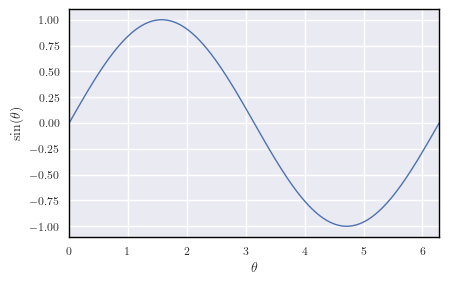

In [35]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [29]:
df_g.describe().closest_to_rho

count    1.331000e+03
mean     1.024658e-01
std      1.035519e-01
min      3.069930e-11
25%      2.666167e-02
50%      6.581040e-02
75%      1.471078e-01
max      4.317004e-01
Name: closest_to_rho, dtype: float64

In [30]:
np.unique(df.q)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

Text(0.5, 0.98, ' closest_to_rho ')

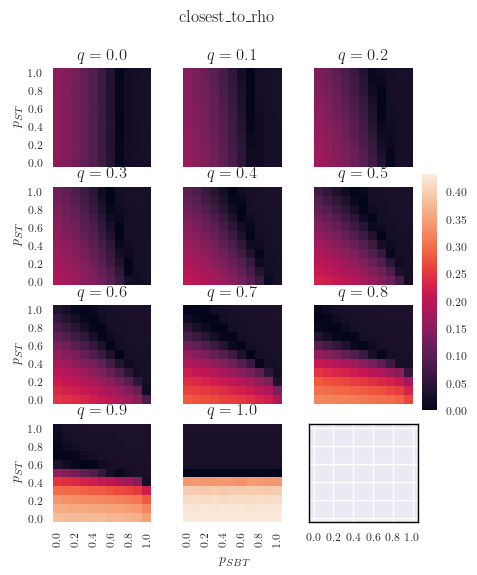

In [70]:



figsize = set_size(width)
figsize = (figsize[0], figsize[1]*2)

fig, axs = plt.subplots(4, 3, figsize=figsize, sharey=True, sharex = True)

cbar_ax = fig.add_axes([.91, .3, .03, .4])

qs = np.unique(get_index_row(df_g, 0))

minval = df_g.describe().closest_to_rho["min"]
maxval = df_g.describe().closest_to_rho["max"]

yticklabels = []

for i, (ax, q) in enumerate(zip(axs.flat, qs)):
    # if i == 0:
    #     continue
    # if i == 10:
    #     continue
    if i == 11:
        continue
    inds2 = get_index_row(df_g, 0) == q

    pv = pd.pivot_table(df_g[inds2], values = "closest_to_rho", index = "p_status", columns = "p_heider")
    
    sns.heatmap(pv, square = True, ax = ax, cbar_ax = cbar_ax, cbar = i == 0, vmin = minval, vmax = maxval)
    
    ax.set_title(r'$q={q}$'.format(q=round(q, 1)))
    ax.invert_yaxis()
    
    fmt = '{:0.1f}'
    xticklabels = []
    for item in ax.get_xticklabels():
        item.set_text(fmt.format(float(item.get_text())))
        xticklabels += [item]
        
    if len(ax.get_yticklabels()) > 0:
        # print(q)
        yticklabels = []
        
        for item in ax.get_yticklabels():
            item.set_text(fmt.format(float(item.get_text())))
            yticklabels += [item]
    else:
        yticklabels2 = []
        for item in yticklabels:
            item.set_text(fmt.format(float(item.get_text())))
            yticklabels2 += [item]
        ax.set_yticklabels(yticklabels2)
    
    # ax.set_yticklabels(yticklabels)
    
    if i%3 == 0:
        # print(yticklabels)
        ax.set_yticklabels(yticklabels)
        # print(ax.get_yticklabels())
        ax.set_ylabel(r'$p_{ST}$')
    else:
        # print(ax.get_yticklabels())
        ax.set_ylabel('')
        ax.tick_params(left=False)
        # print(yticklabels)
    if i == 10:
        ax.set_xlabel(r'$p_{SBT}$')
    else:
        ax.set_xlabel('')
    if i < 9:
        ax.tick_params(bottom=False)
    else:
        ax.set_xticklabels(xticklabels)
    # else: break

# axs.fla

fig.suptitle(' closest_to_rho ')

### Actual plotting heatmaps

On the top of the cell there are two parameters: 
* save_ whether the output should be saved. Note, it might overright old results. 
* log whether the log10 function should be applied to the error values. 

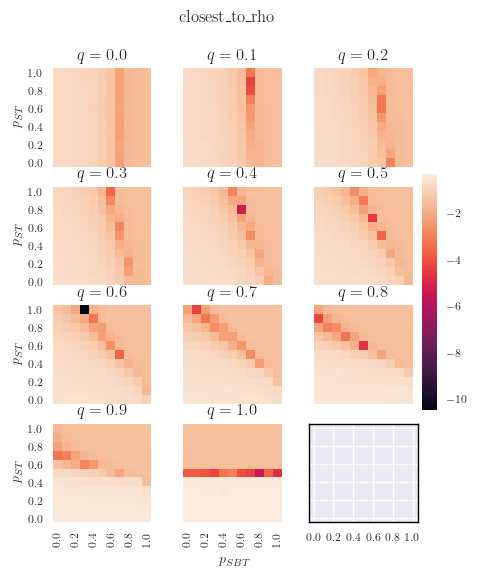

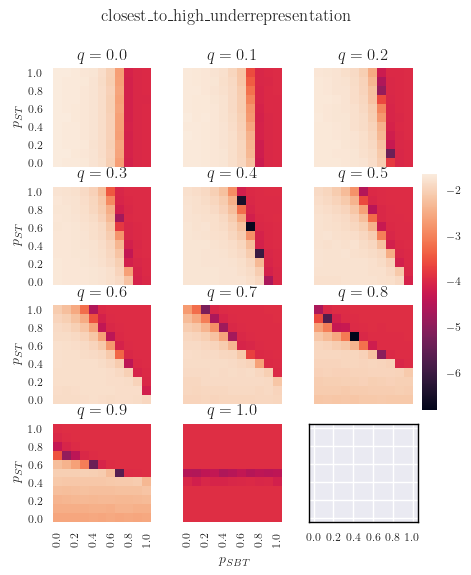

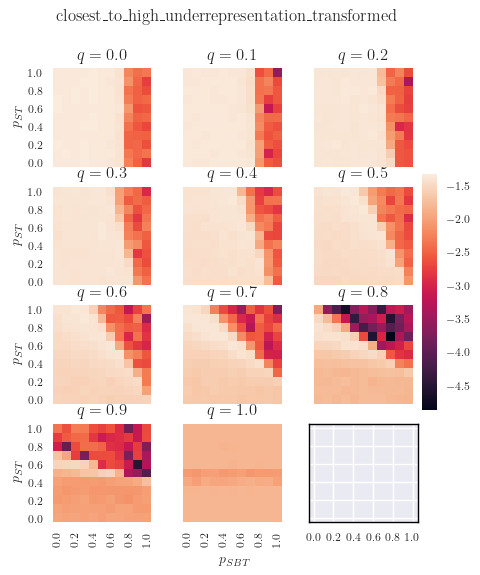

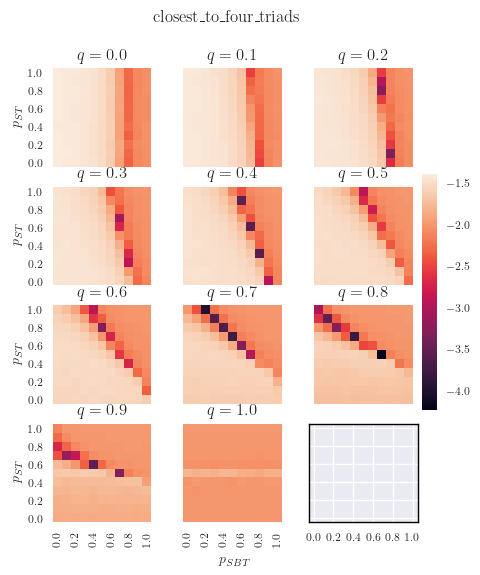

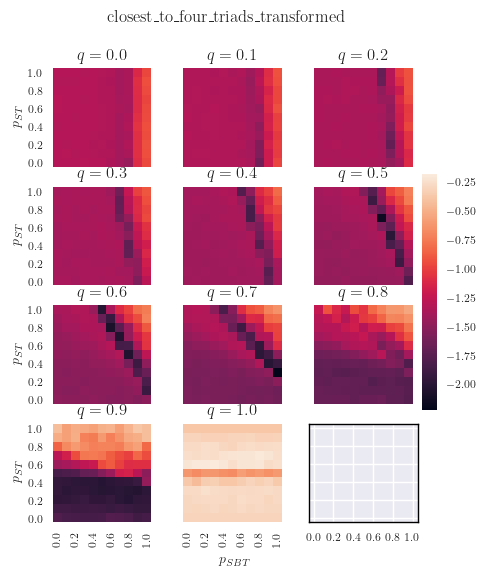

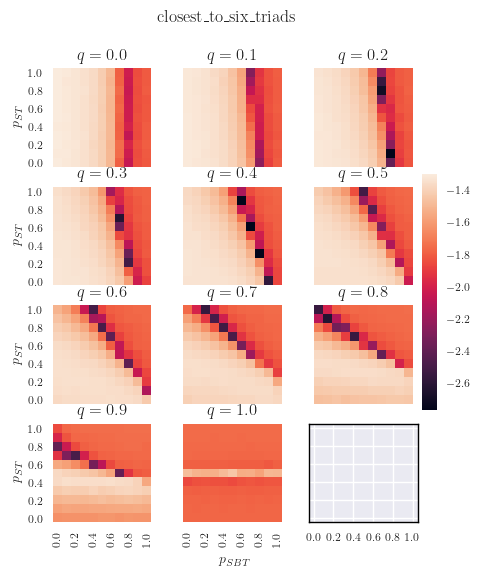

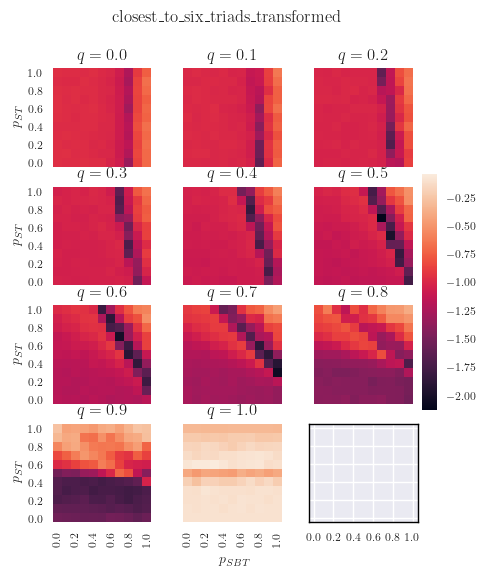

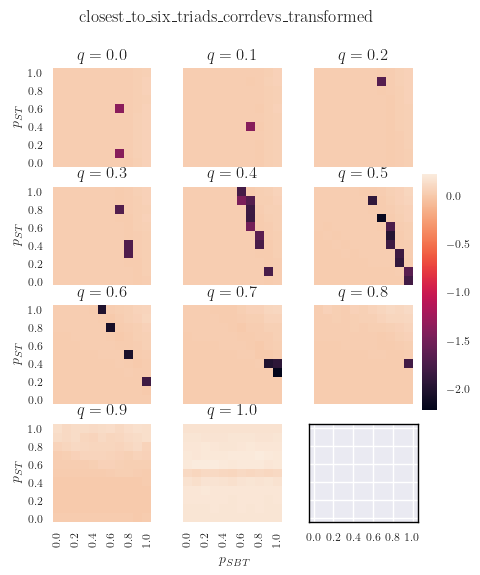

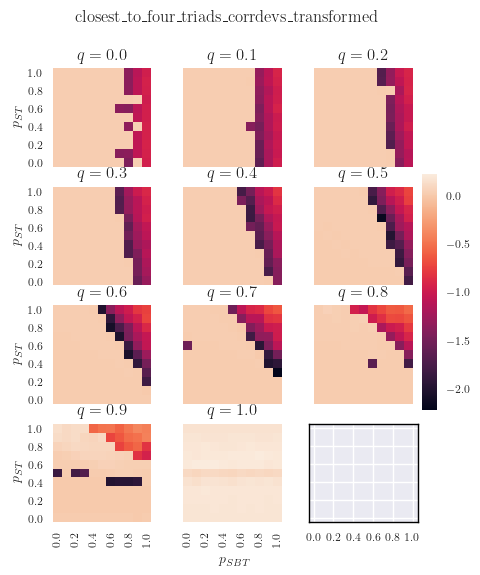

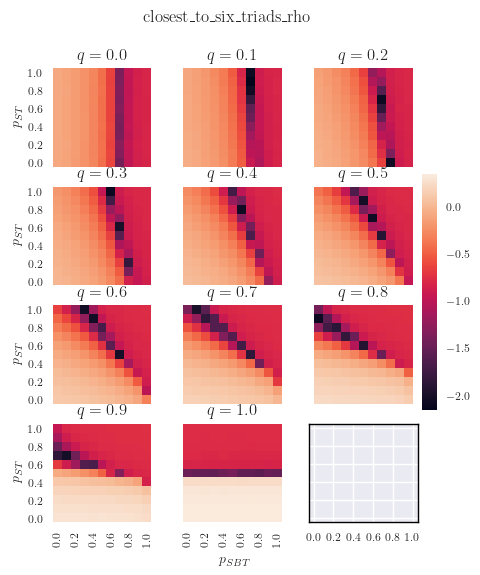

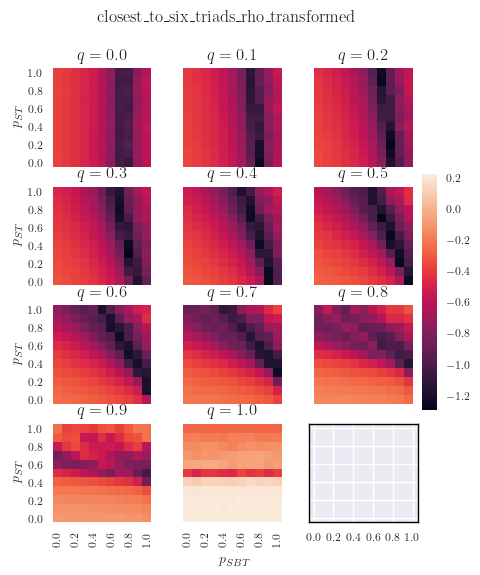

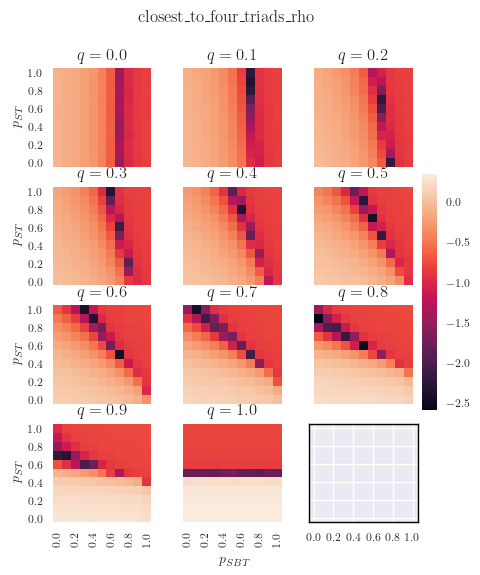

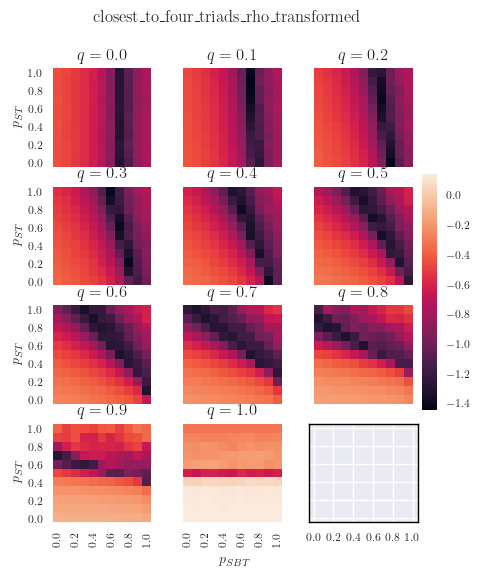

In [71]:

save_ = True
log_ = True

for error_fun in error_functions:
    error_fun_name = error_fun.__name__

    figsize = set_size(width)
    figsize = (figsize[0], figsize[1]*2)

    fig, axs = plt.subplots(4, 3, figsize=figsize, sharey=True, sharex = True)

    cbar_ax = fig.add_axes([.91, .3, .03, .4])

    qs = np.unique(get_index_row(df_g, 0))

    minval = df_g.describe()[error_fun_name]["min"]
    maxval = df_g.describe()[error_fun_name]["max"]
    if log_:
        minval = np.log10(minval)
        maxval = np.log10(maxval)
        
    yticklabels = []
    
    for i, (ax, q) in enumerate(zip(axs.flat, qs)):
        # if i == 0:
        #     continue
        # if i == 10:
        #     continue
        if i == 11:
            continue
        inds2 = get_index_row(df_g, 0) == q

        pv = pd.pivot_table(df_g[inds2], values = error_fun_name, index = "p_status", columns = "p_heider")
        if log_ == True:
            pv = np.log10(pv)
        
        sns.heatmap(pv, square = True, ax = ax, cbar_ax = cbar_ax, cbar = i == 1, vmin = minval, vmax = maxval)
        
        ax.set_title(r'$q={q}$'.format(q=round(q, 1)))
        ax.invert_yaxis()
        
        fmt = '{:0.1f}'
        xticklabels = []
        for item in ax.get_xticklabels():
            item.set_text(fmt.format(float(item.get_text())))
            xticklabels += [item]
            
        if len(ax.get_yticklabels()) > 0:
            # print(q)
            yticklabels = []
            
            for item in ax.get_yticklabels():
                item.set_text(fmt.format(float(item.get_text())))
                yticklabels += [item]
        else:
            yticklabels2 = []
            for item in yticklabels:
                item.set_text(fmt.format(float(item.get_text())))
                yticklabels2 += [item]
            try:
                ax.set_yticklabels(yticklabels2)
            except ValueError:
                pass
        
        # ax.set_yticklabels(yticklabels)
        
        if i%3 == 0:
            # print(yticklabels)
            ax.set_yticklabels(yticklabels)
            # print(ax.get_yticklabels())
            ax.set_ylabel(r'$p_{ST}$')
        else:
            # print(ax.get_yticklabels())
            ax.set_ylabel('')
            ax.tick_params(left=False)
            # print(yticklabels)
        if i == 10:
            ax.set_xlabel(r'$p_{SBT}$')
        else:
            ax.set_xlabel('')
        if i < 9:
            ax.tick_params(bottom=False)
        else:
            ax.set_xticklabels(xticklabels)
    
    fig.suptitle(error_fun_name)
    
    if save_:
        fname = "maps/map_eth_wiki_100M_" + error_fun_name
        # fname = fname + filename_addon
        if log_:
            fname = fname + "_log"
        fname = fname + ".pdf"
        
        fig.savefig(fname, format='pdf', bbox_inches='tight') 

### Barplots

In [33]:
def plot_bar_nets(ax, ydata, yerr, triads_set, title, labels, line_level = 1/3, linewidth = 2, colors=None, width = 0.15, smallest_edge = False, m = 1):
    n_simulated = ydata.copy()
    if yerr is not None:
        n_err = yerr.copy()
    else:
        n_err = None   
#     width = 0.15
    multiplier = 0
    x = np.arange(len(n_simulated.index))*3-1.5
    for i, col in enumerate(ydata.columns):
        offset = multiplier*width*4
        if labels is not None:
            label = labels[i]
        else:
            # label = col
            # print(col)
            if len(col) == 3:
                q, p, ps = col
            elif len(col) == 4:
                _, q, p, ps = col
            elif len(col) == 5:
                _, q, p, ps, step = col
            else:
                q, p, ps = col[:3]
            label = r"$q={q},p_{{SBT}}={p},p_{{ST}}={ps}$".format(q=round(q,2),p=round(p,2),ps=round(ps,2))
            # print(lab)
        if n_err is not None:
            err = n_err[col]
        else:
            err = None
        
        if smallest_edge:
            edgecolor = [colors[i] if val else 'none' for ind, val in enumerate(ydata[col] < 0.01)]
        else:
            edgecolor = ['none' for ind, val in enumerate(ydata[col])]
        rects = ax.bar(x=x+offset, height=n_simulated[col],
                       width=width, label=label, color=colors[i],
                       yerr=err,
                       edgecolor=edgecolor, linewidth=2)
        # ax.bar_label(rects, padding=3)
        multiplier += m

    ax.set_ylabel('Relative density')
    ax.set_title(title)
    if linewidth is not None:
        ax.hlines(y=line_level, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], color='black', linewidth=linewidth, ls='--')
    # ax.legend(loc='best')
    ax.set_xticks(x + width*m+1., triads_set)

def prepare_data4(df_g, triads_set, std_data = None):
    col_names = triads_set
    if not triads_set[0].endswith("_lvl"):
        if triads_set[0] + "_lvl" in df_g.columns:
            col_names = [triad + "_lvl" for triad in triads_set]
    # if not triads_set[0].endswith("_lvl"):
    #     col_names = [triad + "_lvl" for triad in triads_set]
    # else:
    #     col_names = triads_set
    ydata = df_g[col_names].copy()
    n_sum = ydata.sum(axis=1)
    for col in ydata.columns:
        ydata[col] = ydata[col] / n_sum.values
    try:
        ydata = ydata.set_index([ydata.index, df_g.q, df_g.p_heider, df_g.p_status])
    except AttributeError:
        pass
    ydata = ydata.transpose()
    if std_data is not None:
        if not isinstance(std_data, pd.DataFrame):
            yerr = std_data.loc[triads_set].copy().div(n_sum)
        else:
            col_names = [triad + "_lvl_std" for triad in triads_set]
            yerr = std_data[col_names].copy()
            for col in yerr.columns:
                yerr[col] = yerr[col] / n_sum.values  
            yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

def prepare_data5(df_g, triads_set, std_data = None):
    col_names = triads_set
    if not triads_set[0].endswith("_lvl"):
        if triads_set[0] + "_lvl" in df_g.columns:
            col_names = [triad + "_lvl" for triad in triads_set]
    
    ydata = df_g[col_names].copy()
    n_sum = ydata.sum(axis=1)
    for col in ydata.columns:
        ydata[col] = ydata[col] / n_sum.values - 1/3
    try:
        ydata = ydata.set_index([ydata.index, df_g.q, df_g.p_heider, df_g.p_status])
    except AttributeError:
        pass
    ydata = ydata.transpose()
    if std_data is not None:
        if not isinstance(std_data, pd.DataFrame):
            yerr = std_data.loc[triads_set].copy().div(n_sum)
        else:
            col_names = [triad + "_lvl_std" for triad in triads_set]
            # print(col_names)
            yerr = std_data[col_names].copy()
            # print(n_sum.values  )
            for col in yerr.columns:
                yerr[col] = yerr[col] / n_sum.values  
            yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

def prepare_data3(data, triads_sets_average, triads_set_final, std_data = None, norm_fun = prepare_data4):
    n_datas = [norm_fun(data, triads_set, std_data)[0] for triads_set in triads_sets_average]
    n_data = n_datas[0].append(n_datas[1])
    
    ydata = n_data.loc[triads_set_final]
    ydata = ydata.transpose()
    
    if std_data is not None:
        n_stds = [norm_fun(data, triads_set, std_data)[1] for triads_set in triads_sets_average]
        yerr = n_stds[0].append(n_stds[1])
        
        yerr = yerr.loc[triads_set_final]
        yerr = yerr.transpose()
    else:
        yerr = None
    return ydata, yerr

In [37]:
prepare_data5(df.iloc[[inds[-1]]], n1_triads)

(               964
 q              0.1
 p_heider       0.7
 p_status       0.8
 tr3       0.015323
 tr5      -0.008813
 tr6      -0.006511,
 None)

In [38]:
ydata, yerr = prepare_data4(df, n2_triads)
ydata

,0,1,2,3,4,5,6,7,8,9,...,1321,1322,1323,1324,1325,1326,1327,1328,1329,1330
q,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,0.9,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
p_heider,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.6,...,0.5,0.5,0.5,0.5,0.5,0.5,0.6,0.6,0.6,0.6
p_status,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0,0.0,...,0.5,0.6,0.7,0.8,0.9,1.0,0.0,0.1,0.2,0.3
tr1,0.298106,0.308373,0.302309,0.354605,0.619553,0.594731,0.449084,0.368675,0.281298,0.320576,...,0.339800,0.337409,0.341563,0.334199,0.337953,0.339487,0.338726,0.341407,0.338134,0.339877
tr2,0.214794,0.211515,0.212908,0.281499,0.157119,0.075673,0.066191,0.093976,0.078825,0.224552,...,0.324823,0.324351,0.326461,0.326246,0.328894,0.323124,0.326774,0.322991,0.327358,0.323701
tr4,0.487100,0.480112,0.484782,0.363896,0.223329,0.329596,0.484725,0.537349,0.639876,0.454872,...,0.335377,0.338240,0.331976,0.339555,0.333153,0.337388,0.334500,0.335602,0.334507,0.336422


/tmp/ipykernel_83312/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

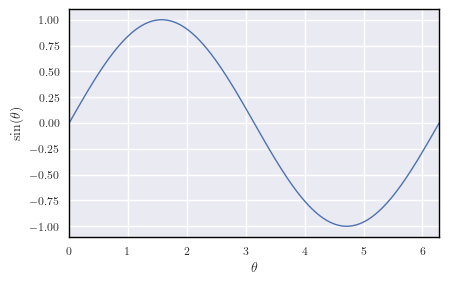

In [39]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [40]:
[len(d) for d in datasets]

[2, 2, 4, 2, 4, 2, 4, 4, 4, 2, 4, 2, 4]

### Actual plotting barplots

Here, we plot best parameter sets for different error functions. These sets were found in the earlier cells and they are stored in variable `inds`. 

On the top of the cell there are some parameters:
* `save_`  # whether to save the plots
* `fun_prepare_data` # It should be `prepare_data5` (data is transformed) or `prepare_data4` (data is not transformed)
* `linewidth` # thickness of linewidth at the expected level
* `orientation` # 'v' or 'h' - vertical or horizontal - how the two subplots are placed
* `which_ticks` # 'zero', 'normal' - whether the expected level should be at 0 or at 1/3
* `which_group` # there can be `group_size` bars (8 at max). If data (`inds`) has more, we need to decide which group of size `group_size` to show. 
* `group_size` # number of sim sets shown in single plot. 

[0.  0.1 0.2 0.3 0.4 0.5 0.6]


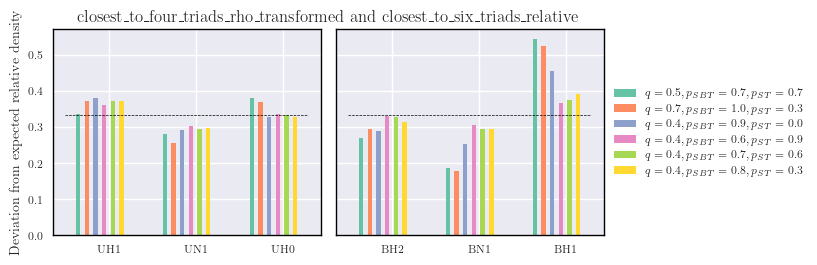

In [132]:
"""Many points
"""


save_ = False
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
which_group = 6 #there can be `group_size` bars (8 at max). If data has more, which to show
group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df.iloc[inds],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df.iloc[inds],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

try:
    plt.title(error_functions[0 + which_group*2].__name__ + " and " + error_functions[1 + which_group*2].__name__)
except IndexError:
    plt.title(error_functions[0 + which_group*2].__name__)

fname = 'barplots_eth_epinions'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [133]:
df.iloc[inds][group_size*which_group:group_size*(which_group+1)]

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed,closest_to_six_triads_relative,closest_to_four_triads_relative
683,0.5,0.7,0.7,0.944459,0,0,0.000125,0.001582,0.001090,0.020808,...,0.010765,0.007284,0.006829,0.006829,0.122861,0.029703,0.118067,0.029248,4.917916,3.270411
190,0.7,1.0,0.3,0.951697,0,0,0.000121,0.001202,0.000730,0.016527,...,0.012789,0.008897,0.005892,0.005892,0.135984,0.033536,0.130634,0.030531,5.230701,3.502771
577,0.4,0.9,0.0,0.900470,0,0,0.001173,0.006977,0.006151,0.065611,...,0.002630,0.032968,1.019360,1.019360,0.058536,0.044150,0.057005,0.030541,2.536281,1.668072
935,0.4,0.6,0.9,0.878919,0,0,0.001835,0.012221,0.011300,0.085489,...,0.001757,0.074600,0.034264,0.034264,0.037198,0.081688,0.035719,0.041352,1.644749,0.733204
943,0.4,0.7,0.6,0.880628,0,0,0.001840,0.011410,0.010299,0.081904,...,0.001705,0.068136,0.031257,0.031257,0.038598,0.075515,0.037168,0.038636,1.552568,0.681344
569,0.4,0.8,0.3,0.876545,0,0,0.002130,0.012434,0.011679,0.088461,...,0.001693,0.062771,1.031077,1.031077,0.035162,0.069465,0.033730,0.037771,1.640386,0.726264


### Notes

1. I like $q=0.8$, $p_{SBT} = 0.8$, $p_{ST} = 0.7$ (very good N2 statistics proper over-rep and underrep for N1 but UH1 is also underrep when it shouldnt be; best in closest to high underrep trans, )
1. I like $q=0.7$, $p_{SBT} = 1.0$, $p_{ST} = 0.3$ (slightly worse than the 1. but still good N2 statistics, better than above N1 stats, best in closest to 4 triads trans, best in closest to 6 triads trans, closest to 6 triads cordevs trans, best in closest to 4 triads cordevs trans, )
1. I like $q=0.5$, $p_{SBT} = 0.7$, $p_{ST} = 0.7$ (slightly worse than above but still good N2 statistics, better than above N1 stats, best in closest to 4 triads trans, best in closest to 6 triads trans, closest to 6 triads cordevs trans, best in  closest to 4 triads cordevs trans, )s trans, best in closest to 6 triads and rho trans)
1. I like $q=0.6$, $p_{SBT} = 0.6$, $p_{ST} = 0.8$ (slightly worse than above but still good N2 statistics, better than above N1 stats, best in closest to 4 triads trans, best in closest to 6 triads corrdev trans, best in  closest to 4 triads cordevs trans, )
1. I like $q=0.6$, $p_{SBT} = 0.7$, $p_{ST} = 0.7$ (slightly worse than above but still good N2 statistics, better than above N1 stats, best in closest to 6 triads trans)

In [63]:
df_g.index

MultiIndex([(0.0, 0.0,                0.0),
            (0.0, 0.0,                0.1),
            (0.0, 0.0,                0.2),
            (0.0, 0.0,                0.3),
            (0.0, 0.0,                0.4),
            (0.0, 0.0,                0.5),
            (0.0, 0.0, 0.6000000000000001),
            (0.0, 0.0, 0.7000000000000001),
            (0.0, 0.0,                0.8),
            (0.0, 0.0,                0.9),
            ...
            (1.0, 1.0,                0.1),
            (1.0, 1.0,                0.2),
            (1.0, 1.0,                0.3),
            (1.0, 1.0,                0.4),
            (1.0, 1.0,                0.5),
            (1.0, 1.0, 0.6000000000000001),
            (1.0, 1.0, 0.7000000000000001),
            (1.0, 1.0,                0.8),
            (1.0, 1.0,                0.9),
            (1.0, 1.0,                1.0)],
           names=['q', 'p_heider', 'p_status'], length=1331)

In [66]:
# sets = [(.8, 0.8, 0.7), (0.7, 0.7000000000000001, 0.8), (0.9, 0.3, 1.)]
six = 0.6000000000000001
sev = 0.7000000000000001
sets = [(.8, 0.8, 0.7000000000000001), (0.7000000000000001, 1., 0.3), 
        (0.5, sev, 0.7000000000000001), (six, six, 0.8), 
        (six, sev, sev),]

df_g.loc[sets]


rho  convergence  sim_run       tr0       tr1  \
q   p_heider p_status                                                       
0.8 0.8      0.7       0.964195          0.0      0.0  0.000030  0.000531   
0.7 1.0      0.3       0.951697          0.0      0.0  0.000121  0.001202   
0.5 0.7      0.7       0.944459          0.0      0.0  0.000125  0.001582   
0.6 0.6      0.8       0.946051          0.0      0.0  0.000126  0.001690   
    0.7      0.7       0.952141          0.0      0.0  0.000059  0.001102   

                            tr2       tr3       tr4       tr5       tr6  ...  \
q   p_heider p_status                                                    ...   
0.8 0.8      0.7       0.000216  0.004367  0.000972  0.003199  0.009275  ...   
0.7 1.0      0.3       0.000730  0.016527  0.002135  0.011330  0.016428  ...   
0.5 0.7      0.7       0.001090  0.020808  0.003182  0.017363  0.023603  ...   
0.6 0.6      0.8       0.001067  0.020048  0.002417  0.016013  0.021925  ...   
    0.7      0.7       0.000765  0.013777  0.002247  0.011559  0.017276  ...   

                       closest_to_four_triads  \
q   p_heider p_status                           
0.8 0.8      0.7                     0.009353   
0.7 1.0      0.3                     0.007439   
0.5 0.7      0.7                     0.005971   
0.6 0.6      0.8                     0.006281   
    0.7      0.7                     0.007315   

                       closest_to_four_triads_transformed  \
q   p_heider p_status                                       
0.8 0.8      0.7                                 0.048531   
0.7 1.0      0.3                                 0.005892   
0.5 0.7      0.7                                 0.006829   
0.6 0.6      0.8                                 0.008247   
    0.7      0.7                                 0.009044   

                       closest_to_six_triads  \
q   p_heider p_status                          
0.8 0.8      0.7                    0.016316   
0.7 1.0      0.3                    0.012789   
0.5 0.7      0.7                    0.010765   
0.6 0.6      0.8                    0.011225   
    0.7      0.7                    0.012968   

                       closest_to_six_triads_transformed  \
q   p_heider p_status                                      
0.8 0.8      0.7                                0.054363   
0.7 1.0      0.3                                0.008897   
0.5 0.7      0.7                                0.007284   
0.6 0.6      0.8                                0.017887   
    0.7      0.7                                0.009546   

                       closest_to_six_triads_corrdevs_transformed  \
q   p_heider p_status                                               
0.8 0.8      0.7                                         1.048531   
0.7 1.0      0.3                                         0.005892   
0.5 0.7      0.7                                         0.006829   
0.6 0.6      0.8                                         0.008247   
    0.7      0.7                                         1.009044   

                       closest_to_four_triads_corrdevs_transformed  \
q   p_heider p_status                                                
0.8 0.8      0.7                                          0.048531   
0.7 1.0      0.3                                          0.005892   
0.5 0.7      0.7                                          0.006829   
0.6 0.6      0.8                                          0.008247   
    0.7      0.7                                          0.009044   

                       closest_to_six_triads_rho  \
q   p_heider p_status                              
0.8 0.8      0.7                        0.159910   
0.7 1.0      0.3                        0.135984   
0.5 0.7      0.7                        0.122861   
0.6 0.6      0.8                        0.125718   
    0.7      0.7                        0.136861   

                       closest_to_six_triads_rho_transfor

[0.  0.1 0.2 0.3 0.4 0.5 0.6]


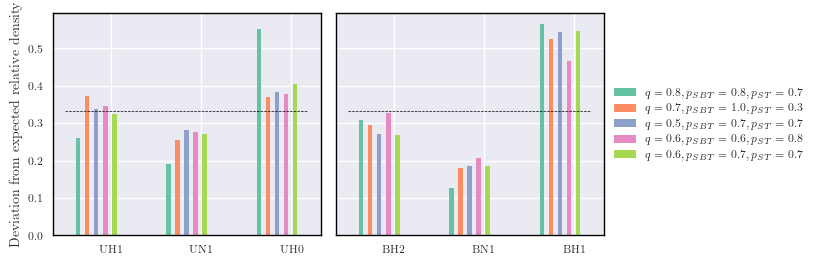

In [72]:
"""Many points
"""


save_ = True
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
# which_group = 6 #there can be `group_size` bars (8 at max). If data has more, which to show
# group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df_g.loc[sets],  triads_set, std_data = None)#df_g_std.loc[sets])

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy() 
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df_g.loc[sets],  triads_set, std_data = None)#df_g_std.loc[sets])

# ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_wiki_eth_100M_sim'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [69]:
df_g.loc[sets]

rho  convergence  sim_run       tr0       tr1  \
q   p_heider p_status                                                       
0.8 0.8      0.7       0.964195          0.0      0.0  0.000030  0.000531   
0.7 1.0      0.3       0.951697          0.0      0.0  0.000121  0.001202   
0.5 0.7      0.7       0.944459          0.0      0.0  0.000125  0.001582   
0.6 0.6      0.8       0.946051          0.0      0.0  0.000126  0.001690   
    0.7      0.7       0.952141          0.0      0.0  0.000059  0.001102   

                            tr2       tr3       tr4       tr5       tr6  ...  \
q   p_heider p_status                                                    ...   
0.8 0.8      0.7       0.000216  0.004367  0.000972  0.003199  0.009275  ...   
0.7 1.0      0.3       0.000730  0.016527  0.002135  0.011330  0.016428  ...   
0.5 0.7      0.7       0.001090  0.020808  0.003182  0.017363  0.023603  ...   
0.6 0.6      0.8       0.001067  0.020048  0.002417  0.016013  0.021925  ...   
    0.7      0.7       0.000765  0.013777  0.002247  0.011559  0.017276  ...   

                       closest_to_four_triads  \
q   p_heider p_status                           
0.8 0.8      0.7                     0.009353   
0.7 1.0      0.3                     0.007439   
0.5 0.7      0.7                     0.005971   
0.6 0.6      0.8                     0.006281   
    0.7      0.7                     0.007315   

                       closest_to_four_triads_transformed  \
q   p_heider p_status                                       
0.8 0.8      0.7                                 0.048531   
0.7 1.0      0.3                                 0.005892   
0.5 0.7      0.7                                 0.006829   
0.6 0.6      0.8                                 0.008247   
    0.7      0.7                                 0.009044   

                       closest_to_six_triads  \
q   p_heider p_status                          
0.8 0.8      0.7                    0.016316   
0.7 1.0      0.3                    0.012789   
0.5 0.7      0.7                    0.010765   
0.6 0.6      0.8                    0.011225   
    0.7      0.7                    0.012968   

                       closest_to_six_triads_transformed  \
q   p_heider p_status                                      
0.8 0.8      0.7                                0.054363   
0.7 1.0      0.3                                0.008897   
0.5 0.7      0.7                                0.007284   
0.6 0.6      0.8                                0.017887   
    0.7      0.7                                0.009546   

                       closest_to_six_triads_corrdevs_transformed  \
q   p_heider p_status                                               
0.8 0.8      0.7                                         1.048531   
0.7 1.0      0.3                                         0.005892   
0.5 0.7      0.7                                         0.006829   
0.6 0.6      0.8                                         0.008247   
    0.7      0.7                                         1.009044   

                       closest_to_four_triads_corrdevs_transformed  \
q   p_heider p_status                                                
0.8 0.8      0.7                                          0.048531   
0.7 1.0      0.3                                          0.005892   
0.5 0.7      0.7                                          0.006829   
0.6 0.6      0.8                                          0.008247   
    0.7      0.7                                          0.009044   

                       closest_to_six_triads_rho  \
q   p_heider p_status                              
0.8 0.8      0.7                        0.159910   
0.7 1.0      0.3                        0.135984   
0.5 0.7      0.7                        0.122861   
0.6 0.6      0.8                        0.125718   
    0.7      0.7                        0.136861   

                       closest_to_six_triads_rho_transfor

In [116]:
ydata, yerr = fun_prepare_data(df.iloc[inds],  n1_triads, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
# ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
ydata

31580     7743                          22141     7743   \
q              0.7       0.8                           0.6       0.8   
p_heider       1.0       1.0                           1.0       1.0   
p_status       1.0       1.0       1.0       1.0       0.9       1.0   
tr3      -0.037950 -0.045562 -0.045562 -0.045562 -0.033318 -0.045562   
tr5       0.045183  0.051090  0.051090  0.051090  0.040609  0.051090   
tr6      -0.007233 -0.005527 -0.005527 -0.005527 -0.007291 -0.005527   

                                 31943     33032  
q                                  1.0       0.8  
p_heider                           1.0       1.0  
p_status       1.0       1.0       1.0       1.0  
tr3      -0.045562 -0.045562 -0.027199 -0.025578  
tr5       0.051090  0.051090  0.021877  0.041294  
tr6      -0.005527 -0.005527  0.005322 -0.015716

## Finding best results assuming rho below 0.9

In [30]:
df[(df.rho < 0.9) & (df.rho > 0.6)]

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_four_triads,closest_to_four_triads_transformed,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed
14,0.9,0.6,0.5,0.638544,0,0,0.074140,0.104327,0.080252,0.172640,...,0.014996,0.036514,0.026880,0.098540,1.036514,1.036514,0.148849,0.147328,0.136965,0.085302
25,0.9,0.7,0.5,0.885772,0,0,0.002797,0.019673,0.009292,0.117016,...,0.000489,0.065379,0.004075,0.189689,1.065379,1.065379,0.045519,0.206266,0.041933,0.081957
57,0.9,1.0,0.4,0.643582,0,0,0.117449,0.104586,0.075548,0.183794,...,0.010924,0.033972,0.027627,0.092540,1.033972,1.033972,0.141854,0.138231,0.125152,0.079663
69,1.0,0.0,0.5,0.783038,0,0,0.033428,0.125129,0.005268,0.203231,...,0.015744,0.235813,0.032950,0.383878,1.235813,1.235813,0.033633,0.384152,0.016428,0.236086
80,1.0,0.1,0.5,0.783298,0,0,0.035205,0.117240,0.005501,0.196146,...,0.014737,0.207234,0.030110,0.327645,1.207234,1.207234,0.030763,0.327906,0.015390,0.207495
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1223,0.0,0.7,0.6,0.715819,0,0,0.025741,0.059234,0.060528,0.138553,...,0.012333,0.042001,0.017066,0.083574,0.042001,0.042001,0.048200,0.096028,0.043467,0.054455
1224,0.0,0.7,0.7,0.721021,0,0,0.024789,0.059598,0.058219,0.138938,...,0.011786,0.040475,0.016487,0.084058,1.040475,1.040475,0.043652,0.094924,0.038951,0.051341
1225,0.0,0.7,0.8,0.718193,0,0,0.026323,0.062153,0.059861,0.140554,...,0.012377,0.039801,0.017375,0.083314,1.039801,1.039801,0.046664,0.095030,0.041666,0.051517
1226,0.0,0.7,0.9,0.722015,0,0,0.024290,0.058142,0.057198,0.137944,...,0.011705,0.040141,0.016279,0.081479,1.040141,1.040141,0.042715,0.092054,0.038141,0.050716


In [31]:
kmin = 3
inds = []
for error_fun in error_functions:
    arr = df[(df.rho < 0.9) & (df.rho > 0.6)][error_fun.__name__]
    inds_p = np.argpartition(arr, kmin)[:kmin]
    inds.extend(inds_p)
    # print("Best for " + error_fun.__name__ + " are:")
    # for ind in inds:
    #     print(df3.iloc[ind])

df[(df.rho < 0.9) & (df.rho > 0.6)].iloc[inds]
        

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_four_triads,closest_to_four_triads_transformed,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed
381,0.6,0.3,1.0,0.794734,0,0,0.009526,0.038639,0.034068,0.140514,...,0.004023,0.044755,0.008986,0.112385,1.044755,1.044755,0.008986,0.112385,0.004023,0.044755
157,1.0,0.8,0.5,0.796414,0,0,0.028626,0.116774,0.004606,0.188162,...,0.012850,0.245853,0.026445,0.401667,1.245853,1.245853,0.026459,0.401673,0.012864,0.245859
934,0.4,0.6,0.8,0.792795,0,0,0.010456,0.038671,0.034594,0.136458,...,0.004634,0.040738,0.008944,0.096272,1.040738,1.040738,0.008963,0.096279,0.004653,0.040745
249,0.8,0.4,0.7,0.872685,0,0,0.002362,0.017771,0.011104,0.105915,...,0.000160,0.050002,0.002822,0.148969,1.050002,1.050002,0.033207,0.161123,0.030546,0.062156
943,0.4,0.7,0.6,0.880628,0,0,0.001840,0.011410,0.010299,0.081904,...,0.000275,0.031257,0.001705,0.068136,0.031257,0.031257,0.038598,0.082893,0.037168,0.046015
935,0.4,0.6,0.9,0.878919,0,0,0.001835,0.012221,0.011300,0.085489,...,0.000279,0.034264,0.001757,0.074600,0.034264,0.034264,0.037198,0.088776,0.035719,0.048440
327,0.9,0.0,0.8,0.871054,0,0,0.001448,0.017236,0.004084,0.058539,...,0.001898,0.137445,0.004020,0.266772,1.137445,1.137445,0.033148,0.278423,0.031026,0.149096
146,1.0,0.7,0.5,0.788413,0,0,0.031000,0.116416,0.005237,0.195338,...,0.013676,0.227661,0.028906,0.368842,1.227661,1.227661,0.029106,0.368922,0.013876,0.227741
348,0.9,0.2,0.7,0.875165,0,0,0.001593,0.017766,0.004701,0.077734,...,0.001360,0.111236,0.003262,0.239571,1.111236,1.111236,0.035612,0.252511,0.033710,0.124176
280,0.8,0.7,0.5,0.870311,0,0,0.003457,0.020881,0.013680,0.124456,...,0.000057,0.049631,0.004084,0.147026,1.049631,1.049631,0.032647,0.158451,0.028620,0.061056


[0.  0.1 0.2 0.3 0.4 0.5]


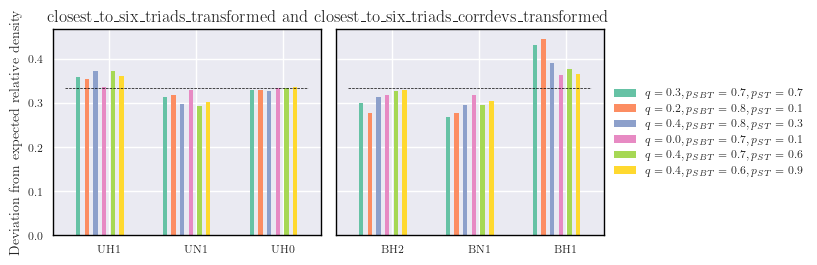

In [52]:
"""Many points
"""


save_ = False
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
which_group = 3 #there can be `group_size` bars (8 at max). If data has more, which to show
group_size = 6

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df[(df.rho < 0.9) & (df.rho > 0.6)].iloc[inds],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df[(df.rho < 0.9) & (df.rho > 0.6)].iloc[inds],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

try:
    plt.title(error_functions[0 + which_group*2].__name__ + " and " + error_functions[1 + which_group*2].__name__)
except IndexError:
    plt.title(error_functions[0 + which_group*2].__name__)

fname = 'barplots_eth_epinions'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [53]:
df[(df.rho < 0.9) & (df.rho > 0.6)].iloc[inds]

,q,p_heider,p_status,rho,convergence,sim_run,tr0,tr1,tr2,tr3,...,closest_to_four_triads,closest_to_four_triads_transformed,closest_to_six_triads,closest_to_six_triads_transformed,closest_to_six_triads_corrdevs_transformed,closest_to_four_triads_corrdevs_transformed,closest_to_six_triads_rho,closest_to_six_triads_rho_transformed,closest_to_four_triads_rho,closest_to_four_triads_rho_transformed
381,0.6,0.3,1.0,0.794734,0,0,0.009526,0.038639,0.034068,0.140514,...,0.004023,0.044755,0.008986,0.112385,1.044755,1.044755,0.008986,0.112385,0.004023,0.044755
157,1.0,0.8,0.5,0.796414,0,0,0.028626,0.116774,0.004606,0.188162,...,0.012850,0.245853,0.026445,0.401667,1.245853,1.245853,0.026459,0.401673,0.012864,0.245859
934,0.4,0.6,0.8,0.792795,0,0,0.010456,0.038671,0.034594,0.136458,...,0.004634,0.040738,0.008944,0.096272,1.040738,1.040738,0.008963,0.096279,0.004653,0.040745
249,0.8,0.4,0.7,0.872685,0,0,0.002362,0.017771,0.011104,0.105915,...,0.000160,0.050002,0.002822,0.148969,1.050002,1.050002,0.033207,0.161123,0.030546,0.062156
943,0.4,0.7,0.6,0.880628,0,0,0.001840,0.011410,0.010299,0.081904,...,0.000275,0.031257,0.001705,0.068136,0.031257,0.031257,0.038598,0.082893,0.037168,0.046015
935,0.4,0.6,0.9,0.878919,0,0,0.001835,0.012221,0.011300,0.085489,...,0.000279,0.034264,0.001757,0.074600,0.034264,0.034264,0.037198,0.088776,0.035719,0.048440
327,0.9,0.0,0.8,0.871054,0,0,0.001448,0.017236,0.004084,0.058539,...,0.001898,0.137445,0.004020,0.266772,1.137445,1.137445,0.033148,0.278423,0.031026,0.149096
146,1.0,0.7,0.5,0.788413,0,0,0.031000,0.116416,0.005237,0.195338,...,0.013676,0.227661,0.028906,0.368842,1.227661,1.227661,0.029106,0.368922,0.013876,0.227741
348,0.9,0.2,0.7,0.875165,0,0,0.001593,0.017766,0.004701,0.077734,...,0.001360,0.111236,0.003262,0.239571,1.111236,1.111236,0.035612,0.252511,0.033710,0.124176
280,0.8,0.7,0.5,0.870311,0,0,0.003457,0.020881,0.013680,0.124456,...,0.000057,0.049631,0.004084,0.147026,1.049631,1.049631,0.032647,0.158451,0.028620,0.061056


[0.  0.1 0.2 0.3 0.4 0.5 0.6]


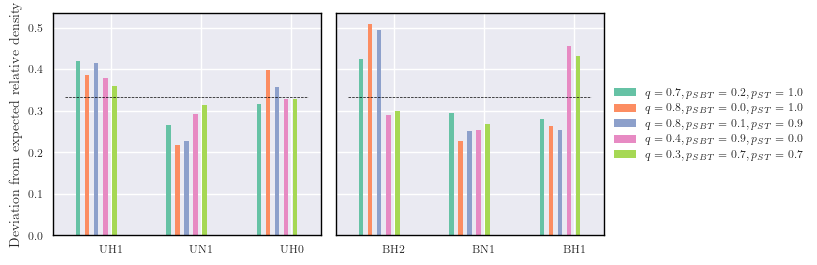

In [137]:
"""Showing results for chosen inds_p
"""


save_ = False
fun_prepare_data = prepare_data4
linewidth = 0.5
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'
which_group = 1 #there can be `group_size` bars (8 at max). If data has more, which to show
group_size = 5

# reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

# sim_data = mean_data.copy()
# sim_data_std = std_data.copy()
# real_data = results_realnet.copy()
# if reverse:
#     order = results_realnet.columns.tolist()
#     order.reverse()
#     real_data = results_realnet[order]
    
#     order = mean_data.columns.tolist()
#     order.reverse()
#     sim_data = sim_data[order]
#     std_data_std = std_data[order]

# triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0]*1.8 , figsize[1])

if fun_prepare_data == prepare_data5:
    line_level = 0
else:
    line_level = 1/3


if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)
# fig, axes = plt.subplots(1, 1, figsize=figsize, sharey=True)

# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:20]
# sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
# print(sim_labels)

triads_set = n1_triads
ydata, yerr = fun_prepare_data(df.iloc[inds_p],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_1$'
plot_bar_nets(axes[0], ydata, None, triads_set, None, labels = None, 
              line_level = line_level, linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
triads_set = n2_triads
ydata, yerr = fun_prepare_data(df.iloc[inds_p],  triads_set, std_data = None)

ydata = ydata[ydata.columns[group_size*which_group:group_size*(which_group+1)]]
ydata = ydata.loc[:,~ydata.columns.duplicated()].copy()
# yerr = yerr[yerr.columns[group_size*which_group:group_size*(which_group+1)]]

title = r'$\Delta_2$'

plot_bar_nets(axes[1], ydata, None, triads_set, None, 
              labels = None, line_level = line_level, 
              linewidth = linewidth, colors=colors, 
              width = 0.15, smallest_edge = True, m = 0.5)


# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in range(2):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    if i==1:
        axes[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])
# else:
#     axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
    
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

# try:
#     plt.title(error_functions[0 + which_group*2].__name__ + " and " + error_functions[1 + which_group*2].__name__)
# except IndexError:
#     plt.title(error_functions[0 + which_group*2].__name__)

fname = 'barplots_eth_epinions'
fname = fname + "_down"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

fname = fname + "_" + str(which_group)

# if reverse is True:
#     fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(fname, format='pdf', bbox_inches='tight') 

In [58]:
col = ydata.columns[1]

In [60]:
[val for ind, val in enumerate(ydata[col] < 0.01)]

[False, True, True]

In [119]:
# Checking if detailed balance equation works
# Let me check pi+ and pi-when ps=0.5. In such a case pi+ and pi- are dependent only on psbt

def pi_plus_minus(pb, ps, q, BN1 = None, UN1 = None, UH0 = None, UH1 = None, UH2 = None, n1 = None, n2 = None, n3 = None, rho = None):
    tr_l = [BN1 , UN1 , UH0 , UH1 , UH2 , n1, n2, n3, rho]
    if not any(tr_l):
        if not any(np.array(tr_l) == 0):
            raise ValueError("Triads densities and link densities not given. ")
    if rho:
        n1 = 3*rho**2 * (1-rho)
        n2 = 3*rho*(1-rho)**2
        n3 = (1-rho)**3
    if all([n1, n2, n3]):
        BN1 = n2/3
        UN1 = n1/3
        UH0 = n1/3
        UH1 = n1/3
        UH2 = n3
    
    plus = q*(BN1 + UN1)*(1-ps) + (1-q)*((1-pb)*(UH1 + UN1) + UH0)
    minus = q*(BN1 + UN1)*ps + (1-q)*(pb*(UH1 + UN1) + UH2)
    return (plus,minus)


q = 0.95
# q=0.15
ps = 0.5
pb = 0.7422145328719724
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

0.0 0.068775


(2.2188545843876417e-05, 0.07305424308175813)

In [74]:
df2.iloc[[301]].p.values[0]

0.1833910034602075

In [58]:
q = 0.1
# q=0.15
ps = 0.8
pb = 0.7226066897347174
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

-2.7755575615628914e-17 0.15419999999999998


(0.00032214188978632596, 0.12281695480086882)

In [75]:
q = 0.95
# q=0.15
ps = 0.55
pb = 0.1833910034602075
rho = 0.85

plus,minus = pi_plus_minus(pb, ps, q, rho = rho)

# assert(abs(plus - minus) < 1e-5)
print(plus-minus, plus)

# q=0.95
row = df2_g.loc[(q,pb,ps)]

BN1 = row[triad_names_map['BN1'] + '_lvl']
UN1 = row[triad_names_map['UN1'] + '_lvl']
UH0 = row[triad_names_map['UH0'] + '_lvl']
UH1 = row[triad_names_map['UH1'] + '_lvl']
UH2 = row[triad_names_map['UH2'] + '_lvl']

# q=0.15
plus,minus = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)

# assert(abs(plus - minus) < 1e-5)
plus-minus, plus

0.0 0.068775


(0.00011295027692963255, 0.07286826851545948)

In [ ]:
301,603

In [80]:
df2.iloc[[301]]

,index,q,p,ps,rho_init,steps,rho,bp,tr0,tr1,...,tr5_qs_b,tr5_qs_f,tr6_qs_m,tr6_qs_s,tr6_qs_b,tr6_qs_f,tr7_qs_m,tr7_qs_s,tr7_qs_b,tr7_qs_f
301,0,0.95,0.183391,0.55,0.85,4000,"[0.8366935483870968, 0.8205645161290323, 0.819...",279.0,"[0.004737903225806452, 0.00625, 0.006989247311...","[0.021740591397849462, 0.02896505376344086, 0....",...,2001.0,3999.0,0.167669,0.007611,2004.0,3971.0,0.302656,0.073614,2000.0,3971.0


In [127]:
row.p.values

array([0.72260669])

In [198]:
row = df2.iloc[[512]]
pb = row.p.values[0]
ps = row.ps.values[0]
q = row.q.values[0]

s = row.steps.values[0]

pluss = np.zeros(s)
minuss = np.zeros(s)

for i in range(s):
    BN1 = row[triad_names_map['BN1']].values[0][i]
    UN1 = row[triad_names_map['UN1']].values[0][i]
    UH0 = row[triad_names_map['UH0']].values[0][i]
    UH1 = row[triad_names_map['UH1']].values[0][i]
    UH2 = row[triad_names_map['UH2']].values[0][i]
    # print(UH2)
    # break
    
    try:
        pluss[i], minuss[i] = pi_plus_minus(pb, ps, q, BN1 = BN1, UN1=UN1, UH0=UH0, UH1=UH1, UH2=UH2)
    except ValueError:
        print(i)
        break

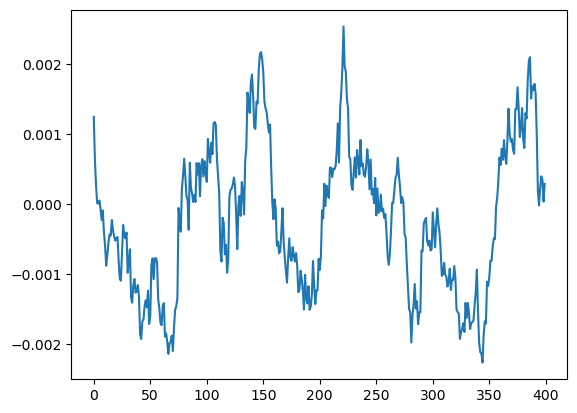

In [199]:
plt.plot(minuss - pluss)

In [130]:
beg = 200
np.mean(-pluss[beg:] + minuss[beg:])

0.0016557634083045026

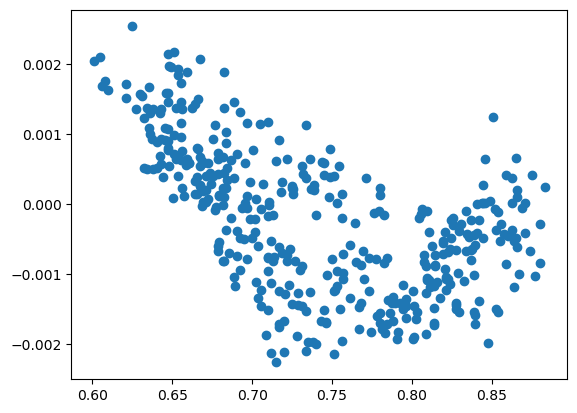

In [200]:
rho = row.rho.values[0]
# rho
# row.rho.values[0]
plt.scatter(rho, minuss - pluss)

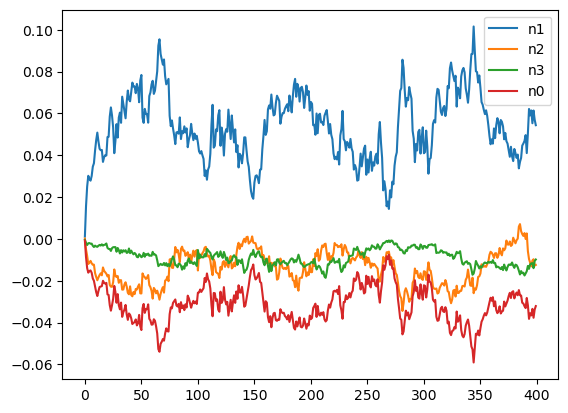

In [201]:
n1_rho = 3*rho**2*(1-rho) 
n2_rho = 3*rho*(1-rho)**2
n3_rho = (1-rho)**3 
n0_rho = rho**3

n2_true = row[triad_names_map['BN1']].values[0] + row[triad_names_map['BH1']].values[0] + row[triad_names_map['BH2']].values[0]
n1_true = row[triad_names_map['UN1']].values[0] + row[triad_names_map['UH1']].values[0] + row[triad_names_map['UH0']].values[0]
n3_true = row[triad_names_map['UH2']].values[0]
n0_true = row[triad_names_map['BH0']].values[0]

plt.plot(n1_rho - n1_true)
plt.plot(n2_rho - n2_true)
plt.plot(n3_rho - n3_true)
plt.plot(n0_rho - n0_true)

plt.legend(['n1', 'n2', 'n3', 'n0'])

/tmp/ipykernel_76370/1355872723.py:44: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Text(0, 0.5, '$\\sin (\\theta)$')

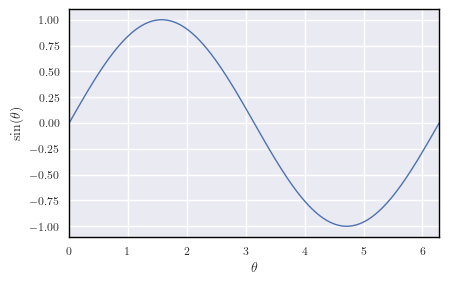

In [129]:
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

import numpy as np
import matplotlib.pyplot as plt

# Using seaborn's style
plt.style.use('seaborn')
width = 345
# width = 1000

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 1
plt.rcParams.update(tex_fonts)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 4

x = np.linspace(0, 2*np.pi, 100)
# Initialise figure instance
fig, ax = plt.subplots(1, 1, figsize=set_size(width))
# Plot
ax.plot(x, np.sin(x))
ax.set_xlim(0, 2 * np.pi)
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$\sin (\theta)$')



In [130]:
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])
figsize = (figsize[0] * 1.7, figsize[1] * 1.7)
# figsize = 

In [ ]:
"""Four triads
"""


save_ = True
fun_prepare_data = prepare_data2
linewidth = None
orientation = 'h' # 'v' or 'h'
which_ticks = 'zero' #'zero', 'normal'

reverse = True

width = 345
figsize = set_size(width)
# figsize = (figsize[0] * 1.7, figsize[1])

sim_data = mean_data.copy()
sim_data_std = std_data.copy()
real_data = results_realnet.copy()
if reverse:
    order = results_realnet.columns.tolist()
    order.reverse()
    real_data = results_realnet[order]
    
    order = mean_data.columns.tolist()
    order.reverse()
    sim_data = sim_data[order]
    std_data_std = std_data[order]

triads = ['tr2', 'tr6', 'tr5', 'tr1']
all_sets = [n1_triads, n2_triads]

if orientation == 'v':
    figsize = (figsize[0] , figsize[1] * 1.5)
elif orientation == 'h':
    figsize = (figsize[0] , figsize[1])
# figsize = 

if fun_prepare_data == prepare_data2:
    line_level = 0
else:
    line_level = 1/3


sim_pos = 0
real_pos = 1
if orientation == 'v':
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharey=True)
elif orientation == 'h':
    fig, axes = plt.subplots(1, 2, figsize=figsize, sharey=True)


# Simulated nets
colors = sns.color_palette("Set2").as_hex()[:8]
sim_labels = [r'$q={q:.2f}$'.format(q=q) for q in sim_data.columns.values]
print(sim_labels)
# plot_bar_simulatednets(ax=axes[sim_pos, 0], triads_set=n1_triads, title='n1', labels=sim_labels, colors=colors)
triads_set = triads
ydata, yerr = prepare_data3(sim_data, all_sets, triads_set, std_data = sim_data_std)
print(ydata)
title = r'$\Delta_1$'
plot_bar_nets(axes[sim_pos], ydata, yerr, triads_set, None, labels = sim_labels, line_level = line_level, linewidth = linewidth, colors=colors[0:3][::-1], width = 0.2, smallest_edge = True)
# plot_bar_simulatednets(ax=axes[sim_pos, 1], triads_set=n2_triads, title='n2', labels=sim_labels, colors=colors)
# triads_set = n2_triads
# ydata, yerr = fun_prepare_data(mean_data, triads_set, std_data = std_data)
# title = r'$\Delta_2$'

# plot_bar_nets(axes[sim_pos, 1], ydata, yerr, triads_set, title, labels = sim_labels, line_level = line_level, colors=colors, linewidth = linewidth)

# Realnets
triads_set = triads
ydata, _ = prepare_data3(real_data, all_sets, triads_set)

plot_bar_nets(axes[real_pos], ydata, None, triads_set, None, labels = None, line_level = line_level, colors=colors[3:], linewidth = linewidth, width = 0.2)
# plot_bar_realnets(ax=axes[real_pos, 1], triads_set=n2_triads, title='')
# triads_set = n2_triads

# ydata, _ = fun_prepare_data(results_realnet, triads_set)

# plot_bar_nets(axes[real_pos, 1], ydata, None, triads_set, None, labels = None, line_level = line_level, colors=colors, linewidth = linewidth)

# fix tick rotations
for ax in axes.flatten():
    for tick in ax.get_xticklabels():
        tick.set_rotation(0)
# fix tick labels
for ax in axes.flatten():
    ax.set_xticklabels([triad_names_map[tick.get_text()] for tick in ax.get_xticklabels()])
# drop double legend
for i in (sim_pos, real_pos):
#     axes[i, 1].get_legend().remove()
#     axes[i,1].set_ylabel('')
    # set legend to left top corner
    axes[i].legend(loc='upper left')
    axes[i].set_ylabel('')
    
ticks = axes[i].get_yticklabels()
ticks = axes[i].get_yticks()
print(ticks)
if which_ticks == "normal":
    ticks2 = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6]) - 1/3
    axes[1].set_yticks(ticks2)
    # axes[i,0].set_yticks(ticks - 0.1)
    axes[i].set_yticklabels([r'{tick:.1f}'.format(tick=tick+1/3) for tick in ticks2])

fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
# plt.xlabel("common X")
plt.ylabel("Deviation from expected relative density")

fname = 'barplots_sim_real'
fname = fname + "_down"
fname = fname + "_down_nx"
fname = fname + "_v2"

fname = fname + "_" + orientation
fname = fname + "_" + which_ticks

if reverse is True:
    fname = fname + "_rev"

if linewidth is None:
    fname = fname + "_noline"

fig.tight_layout()
plt.show()
if save_:
    fname = fname + ".pdf"
    fig.savefig(save_fig_path / fname, format='pdf', bbox_inches='tight') 